--- Khối 1: Nhập Thư viện và Cài đặt ---

--- Khối 2: Định nghĩa Hằng số và Đường dẫn ---
Thư mục chứa scaler/encoder: E:\important\AI\time_series\preprocessed_data
Thư mục chứa model: E:\important\AI\time_series\models
Các mã cổ phiếu sẽ dự đoán: ['ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB', 'STB', 'TCB', 'TPB', 'VCB', 'VIB']

--- Khối 3: Hàm Lấy Dữ liệu Mới ---
Đang lấy dữ liệu từ 2025-04-07 đến 2025-04-21 cho 12 mã...
  Đang lấy dữ liệu cho: ACB
  [ACB] Đã loại bỏ 3355 hàng có NaN trong OHLCV.
  [ACB] Lấy dữ liệu thành công. Shape: (456, 5)
  Đang lấy dữ liệu cho: BID
  [BID] Đã loại bỏ 3370 hàng có NaN trong OHLCV.
  [BID] Lấy dữ liệu thành công. Shape: (441, 5)
  Đang lấy dữ liệu cho: CTG
  [CTG] Đã loại bỏ 3361 hàng có NaN trong OHLCV.
  [CTG] Lấy dữ liệu thành công. Shape: (450, 5)
  Đang lấy dữ liệu cho: HDB
  [HDB] Đã loại bỏ 3372 hàng có NaN trong OHLCV.
  [HDB] Lấy dữ liệu thành công. Shape: (439, 5)
  Đang lấy dữ liệu cho: LPB
  [LPB] Đã loại bỏ 3356 hàng có NaN trong O

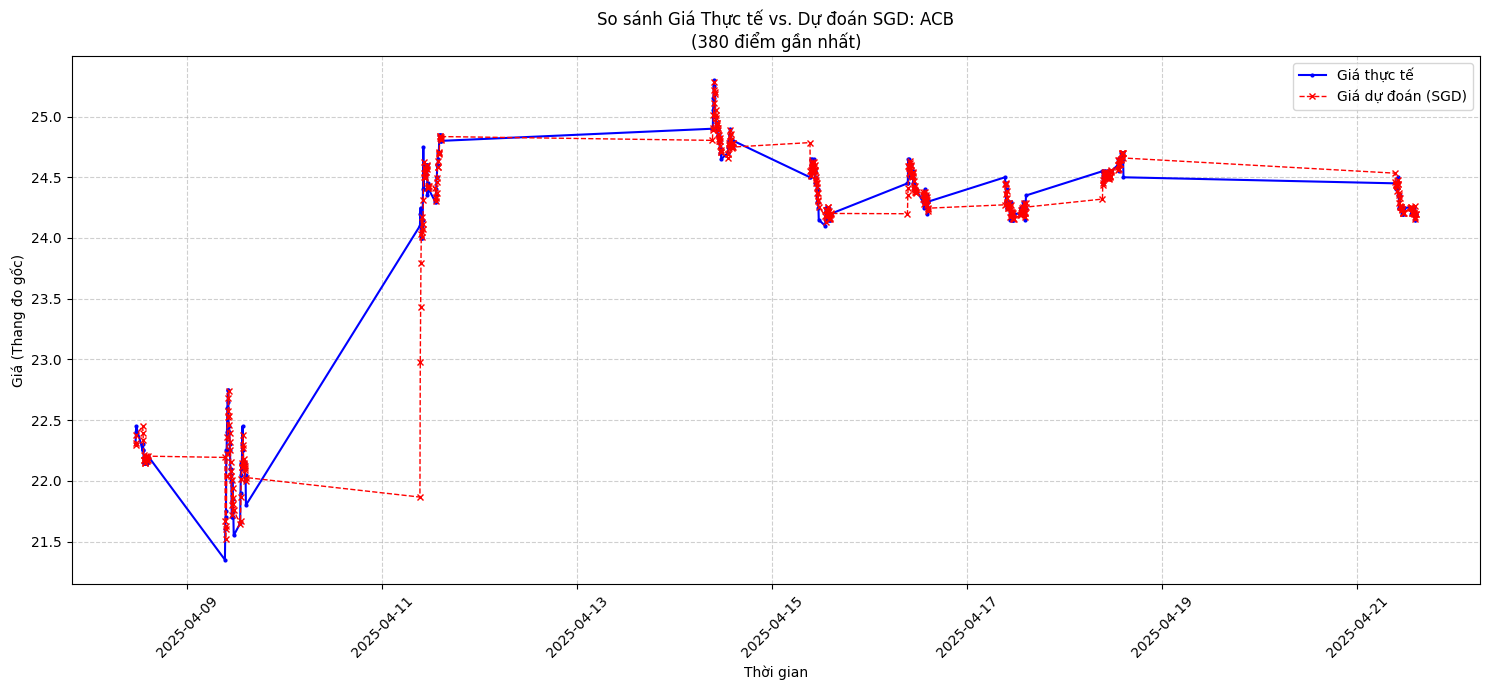

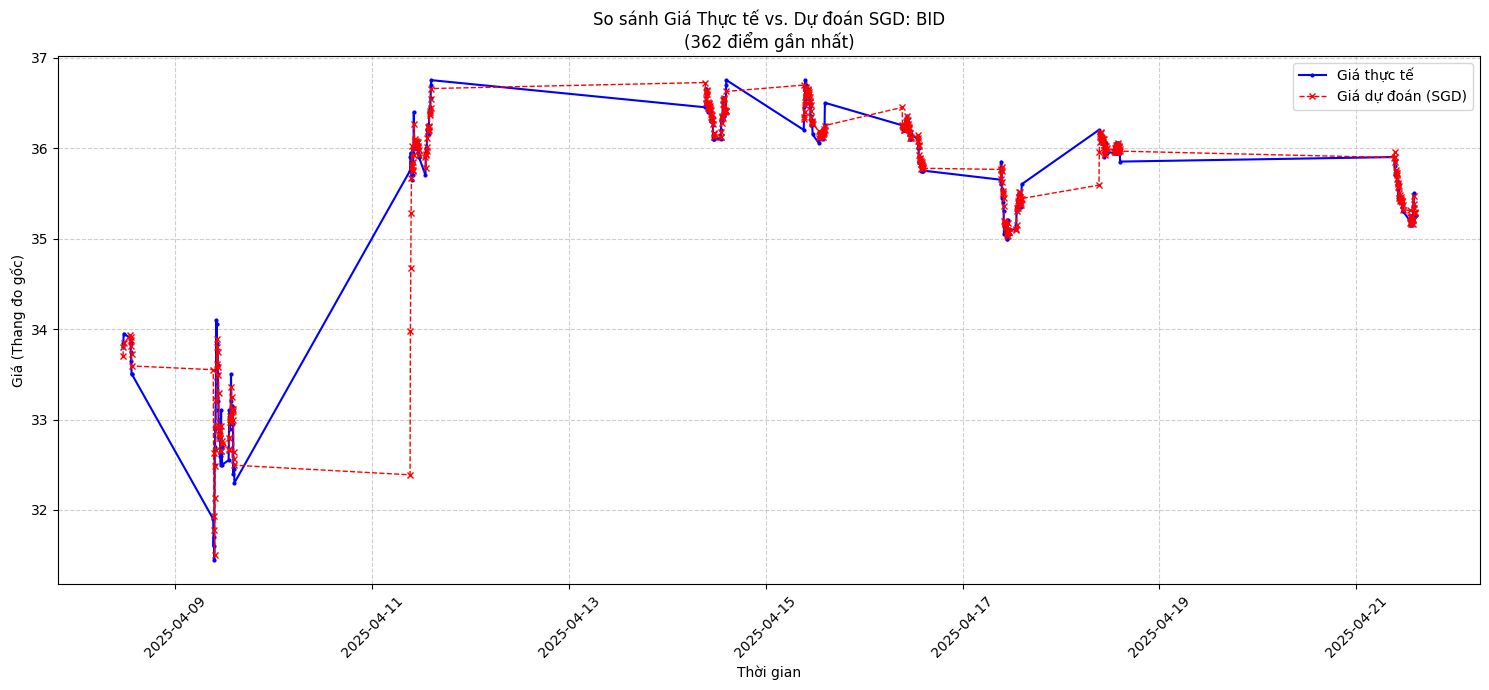

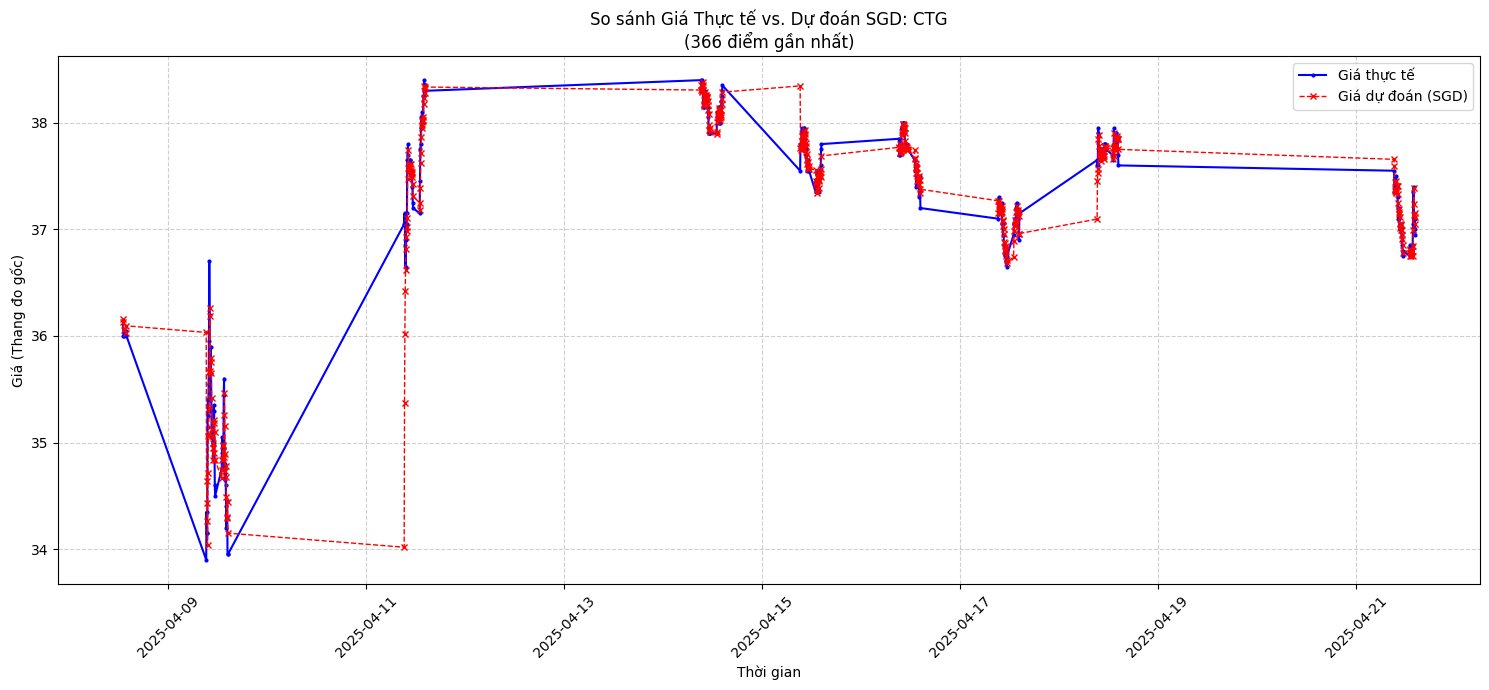

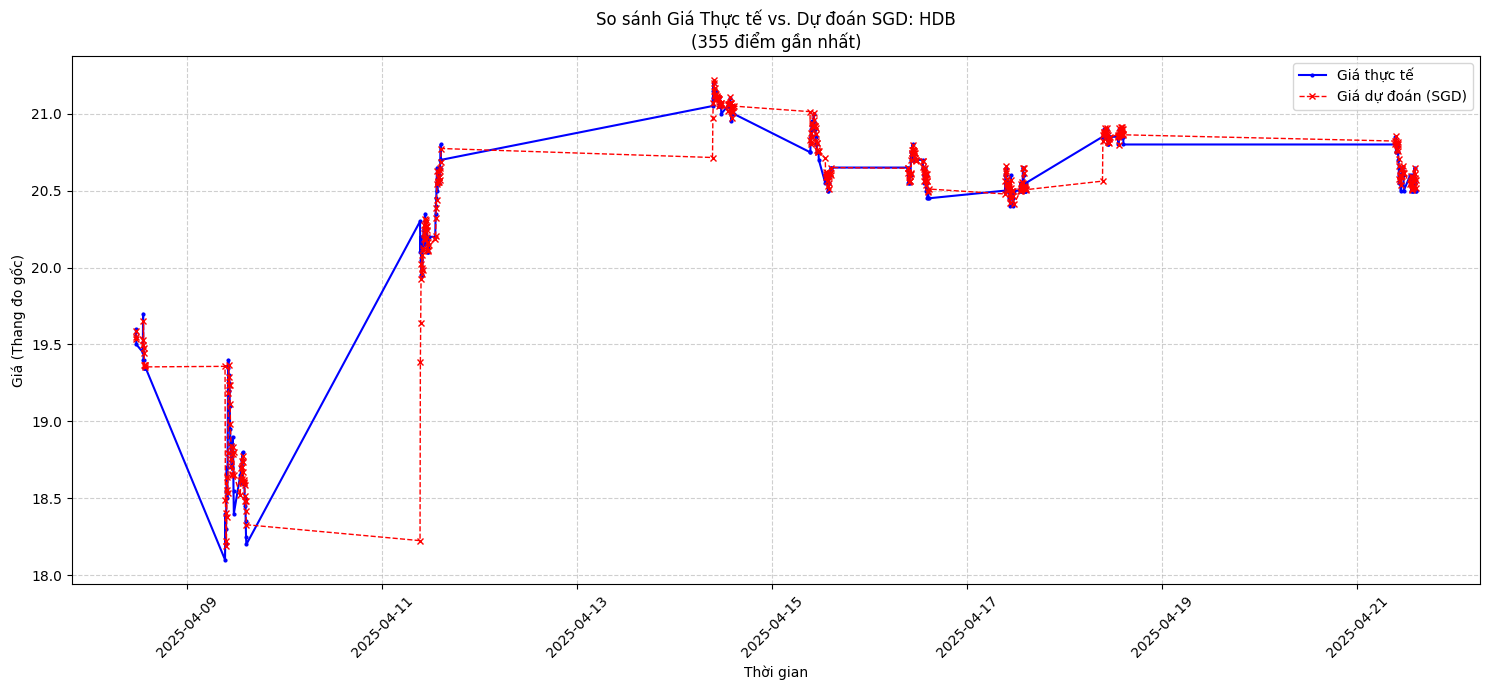

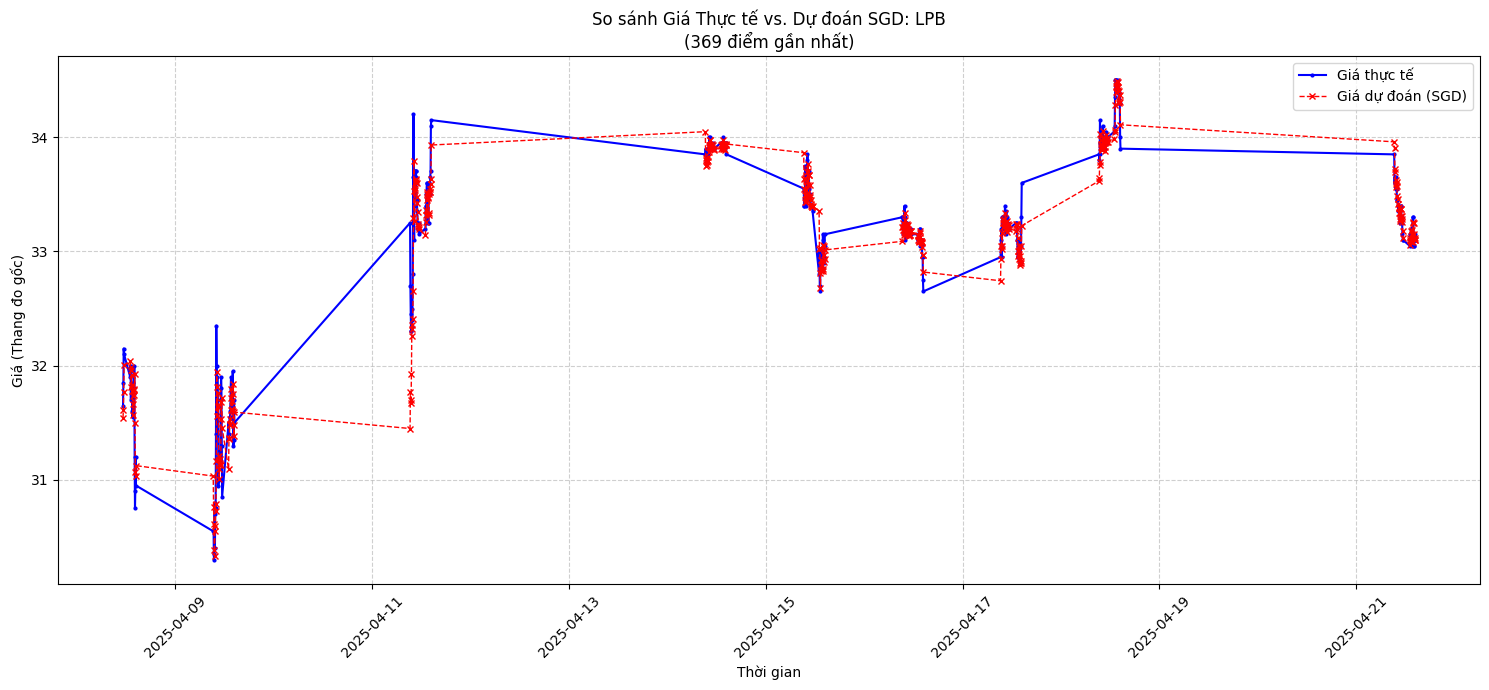

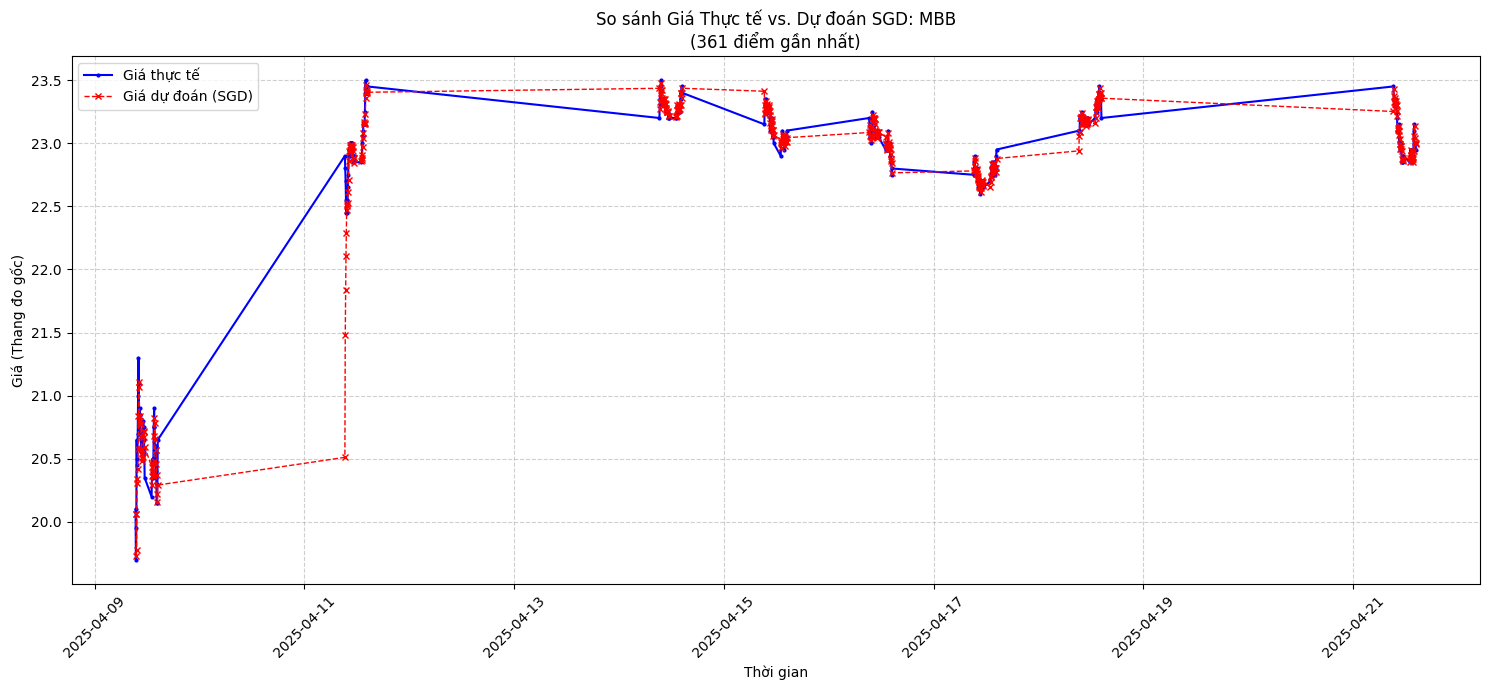

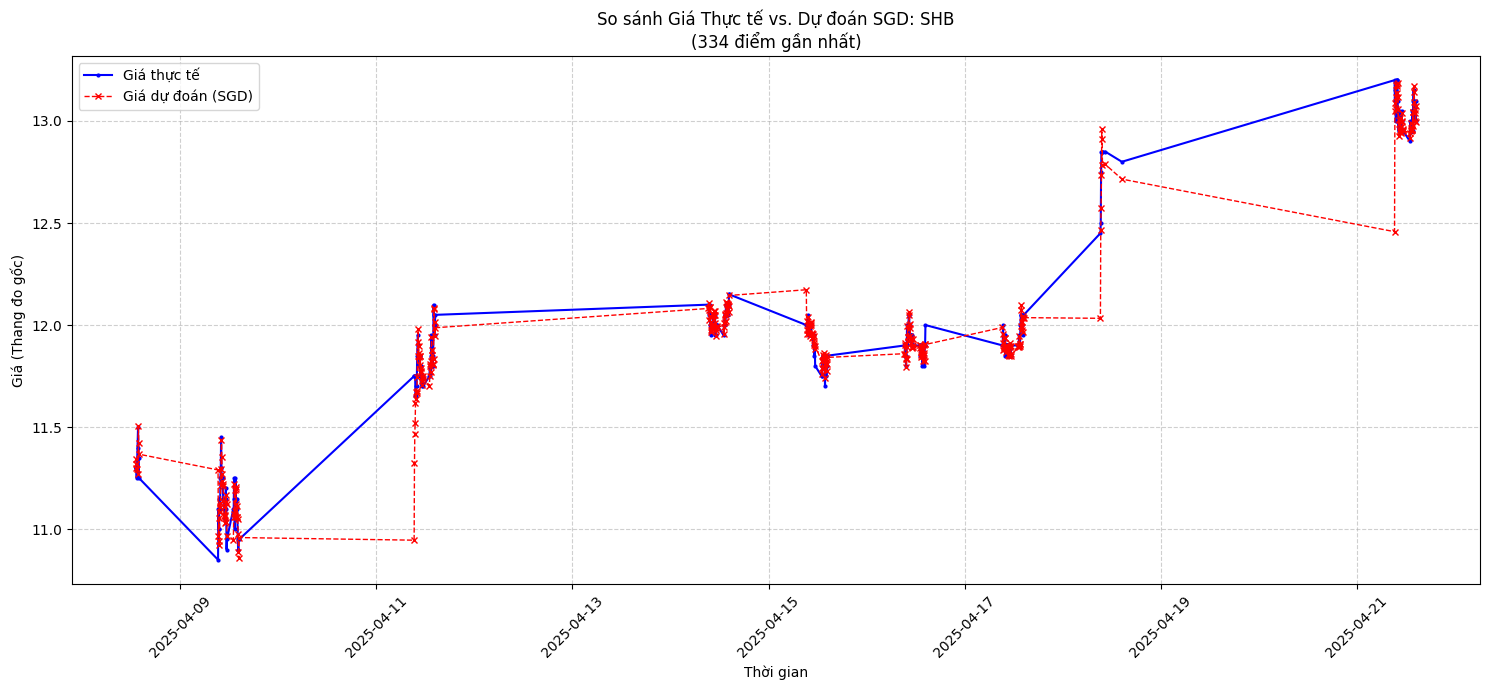

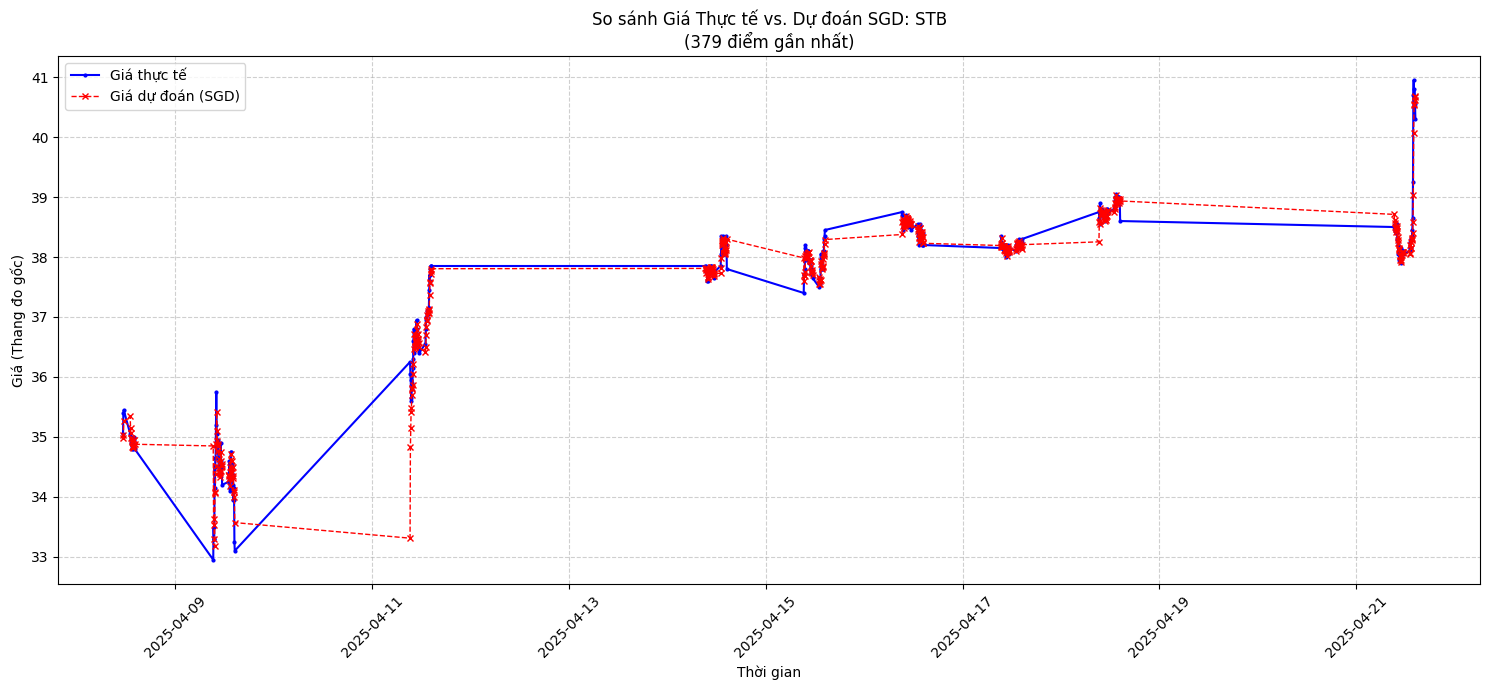

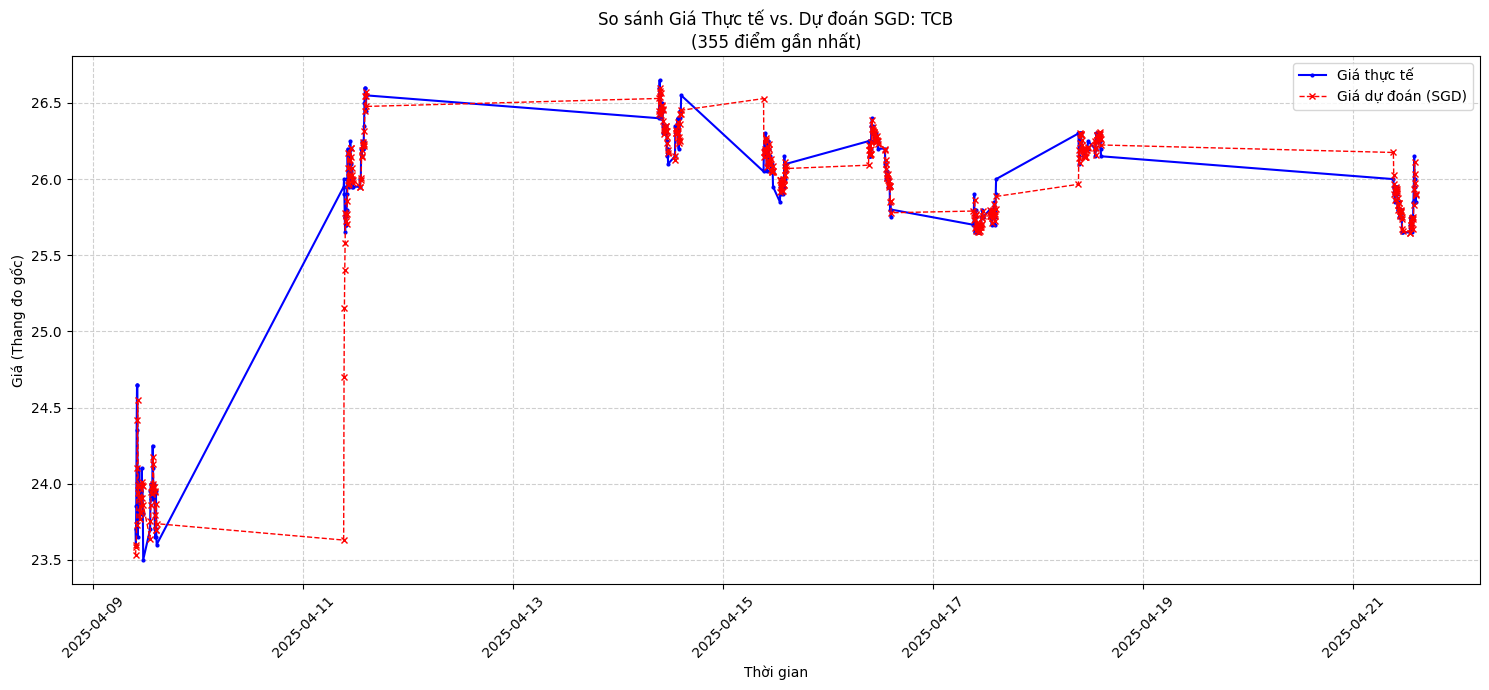

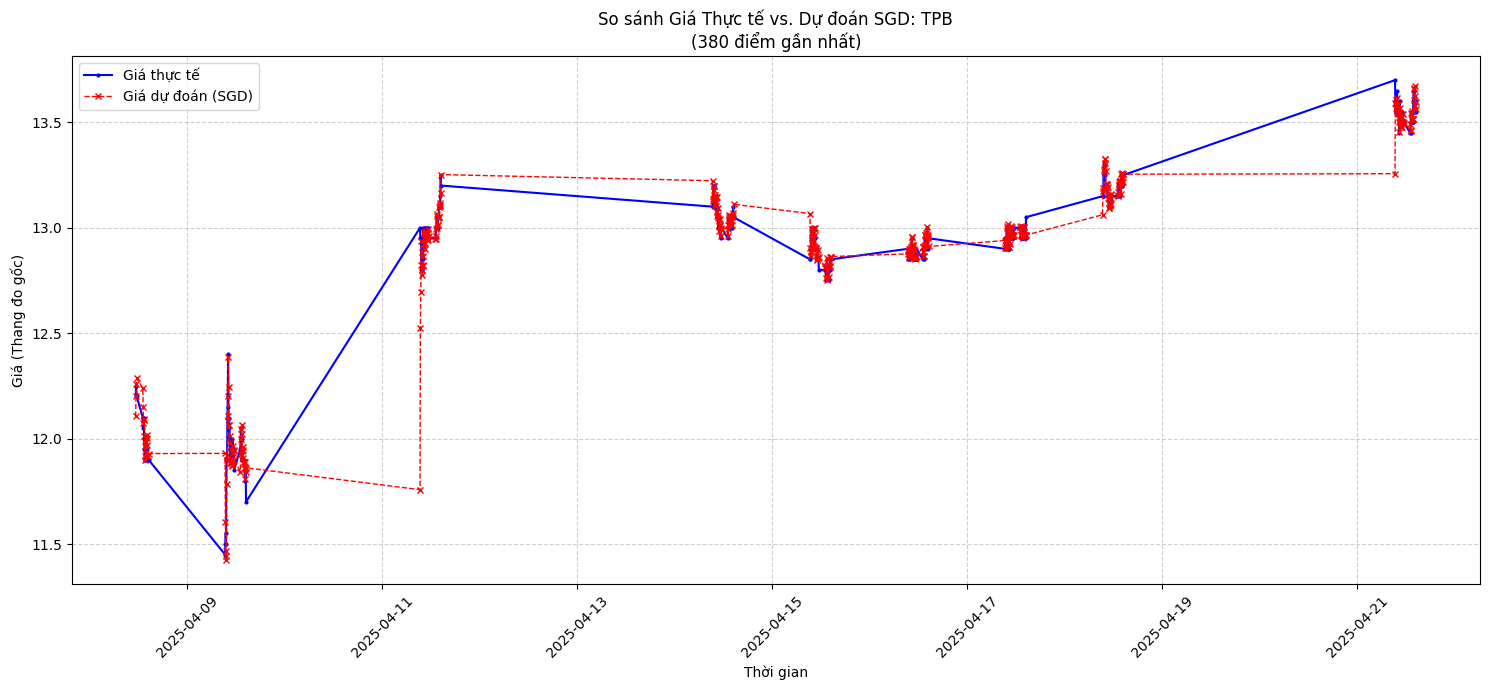

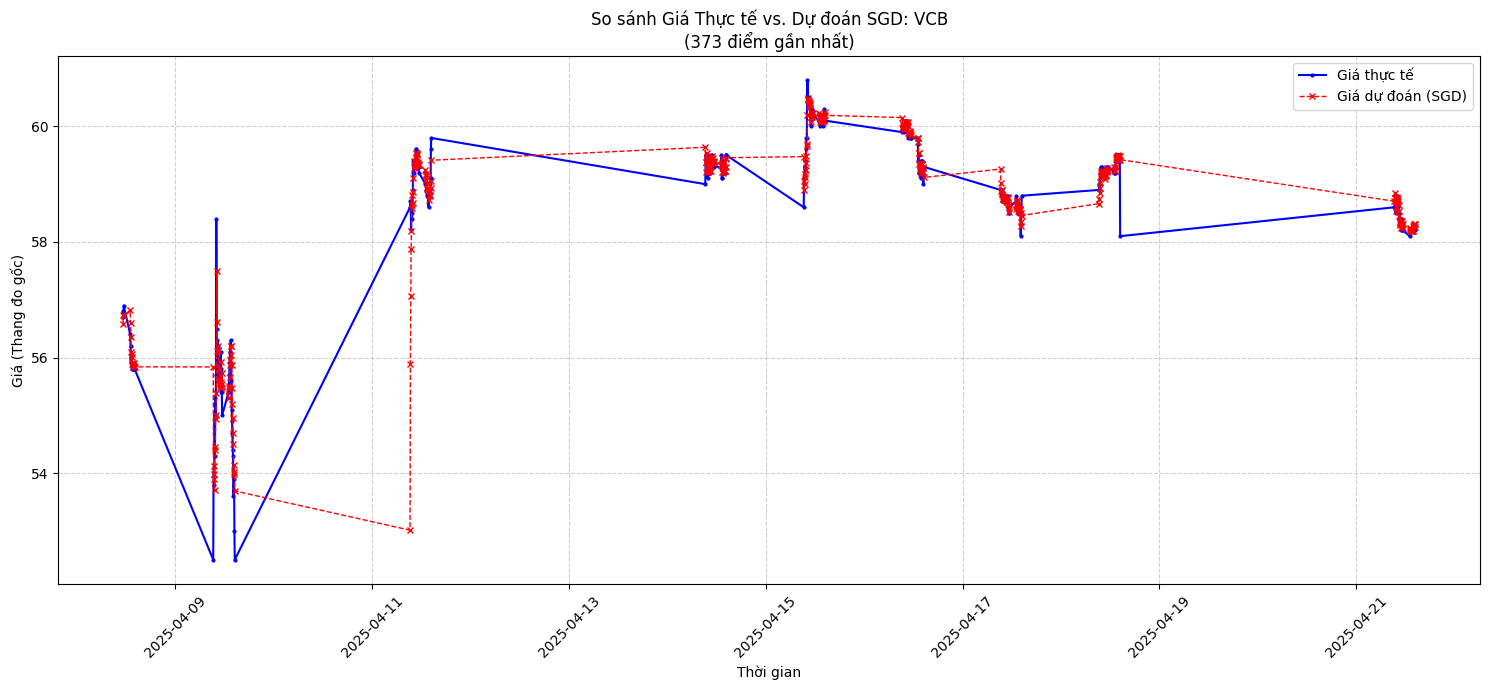

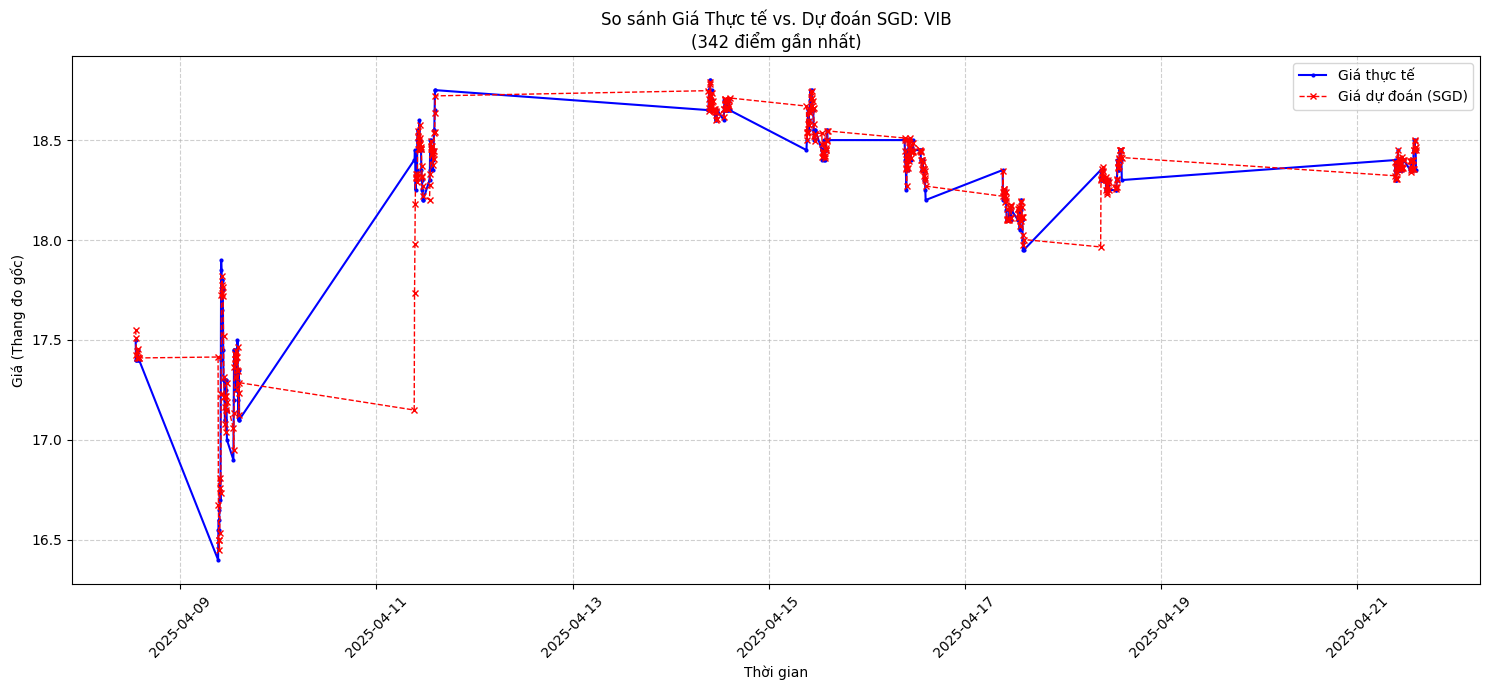


Hoàn tất vẽ biểu đồ. Kiểm tra các cửa sổ đồ thị đã hiển thị.


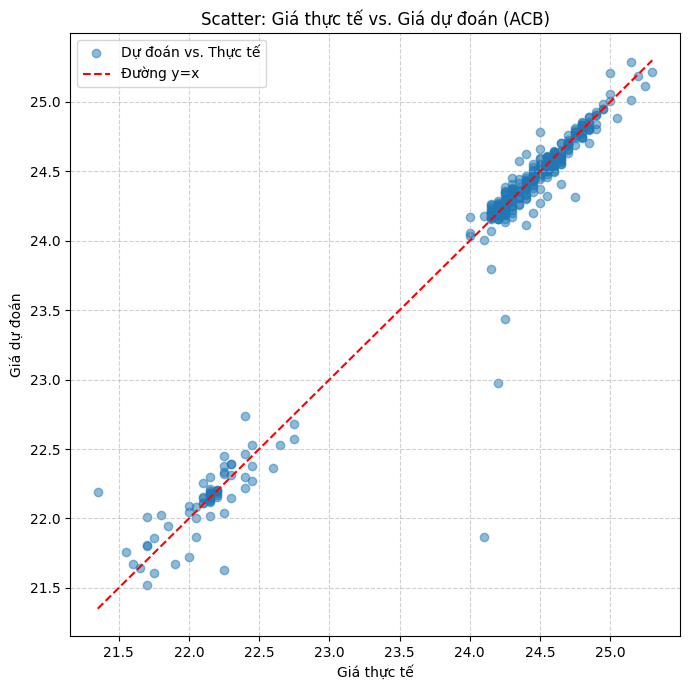

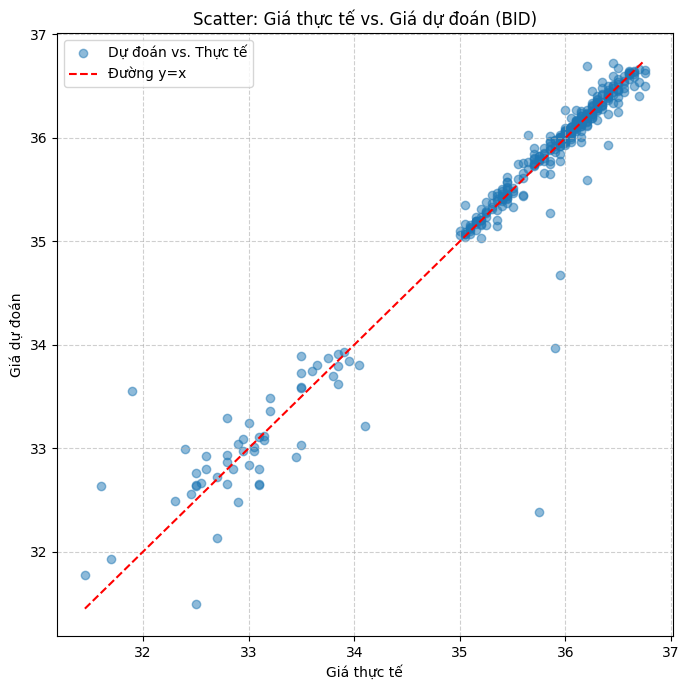

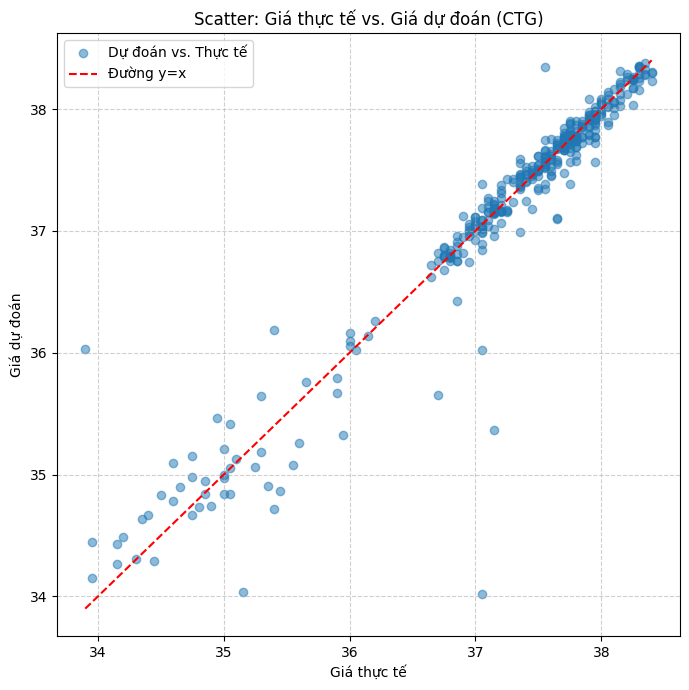

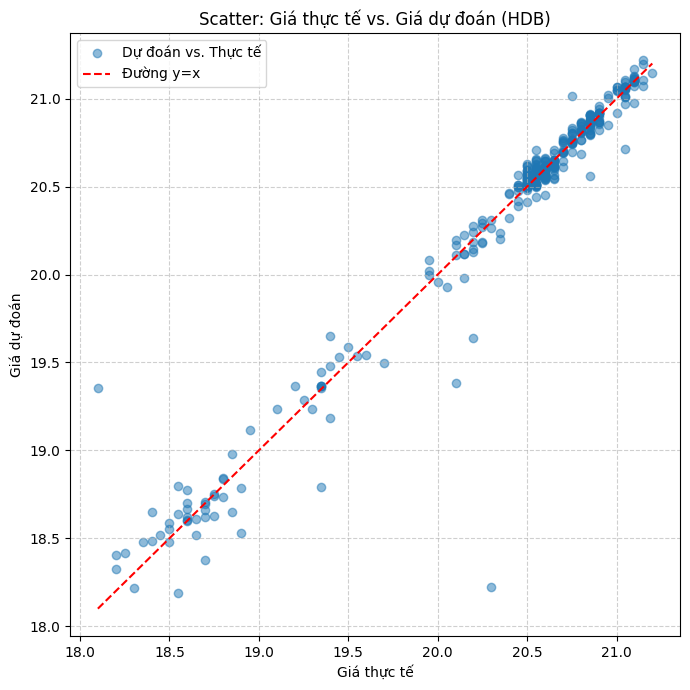

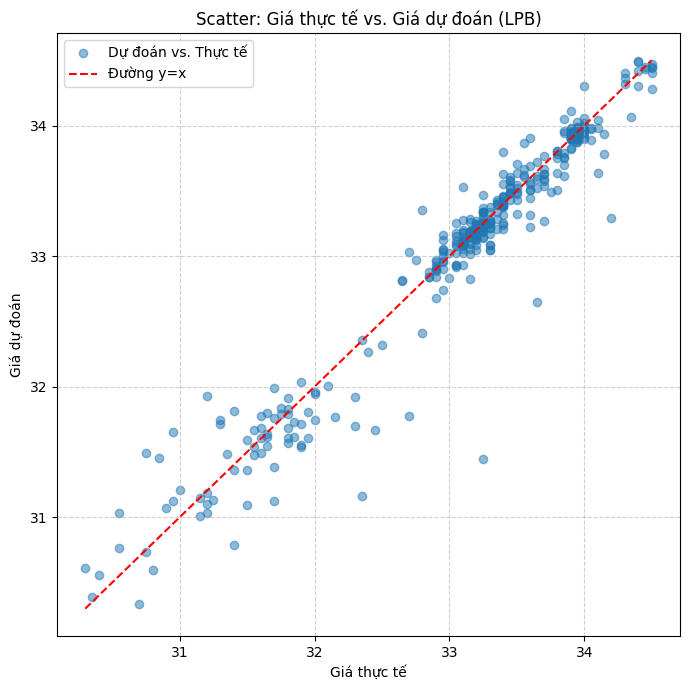

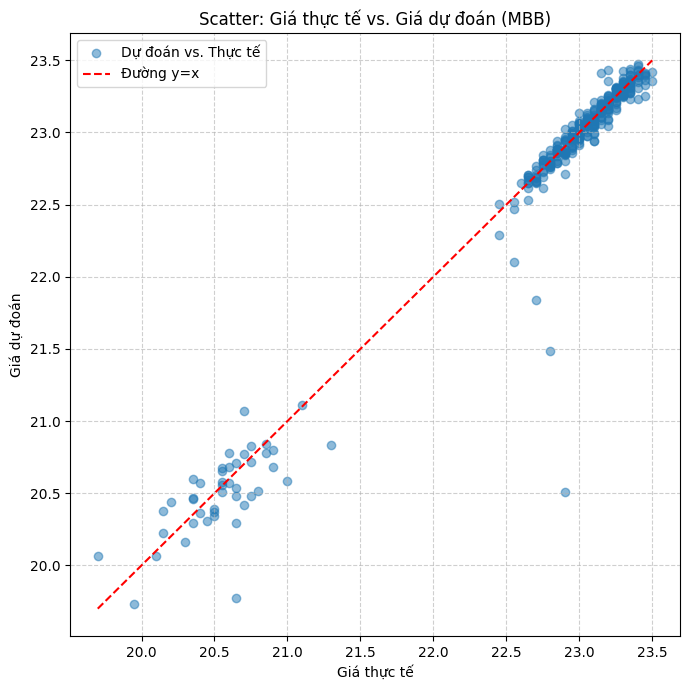

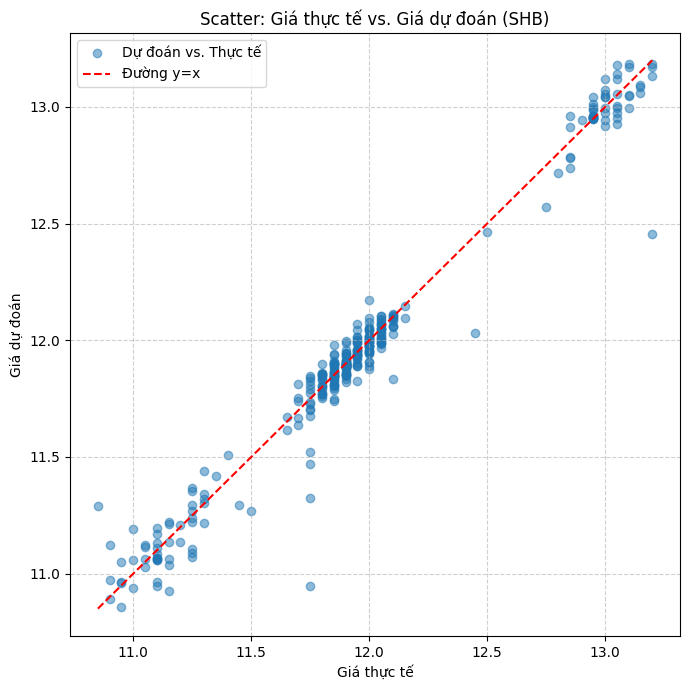

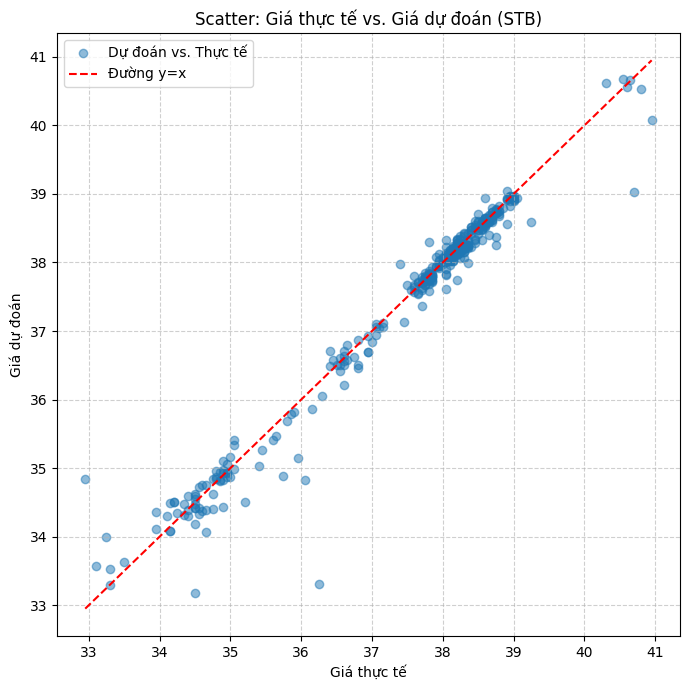

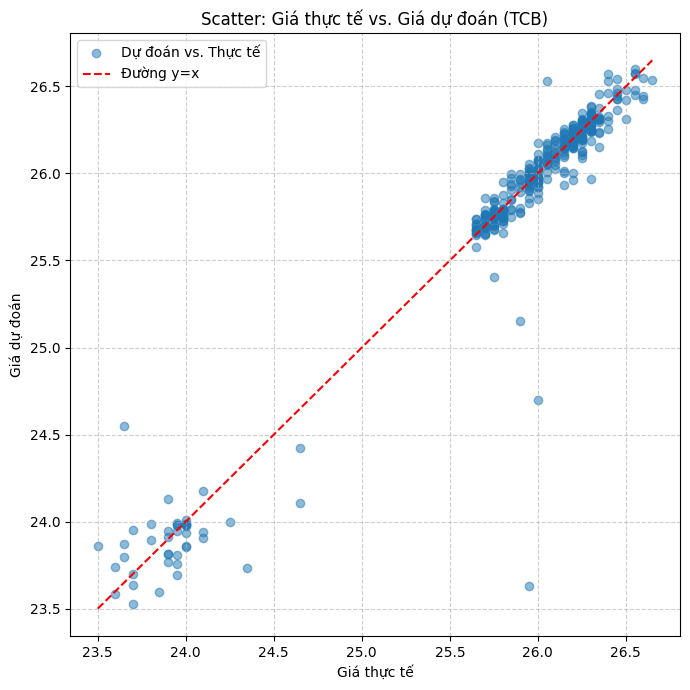

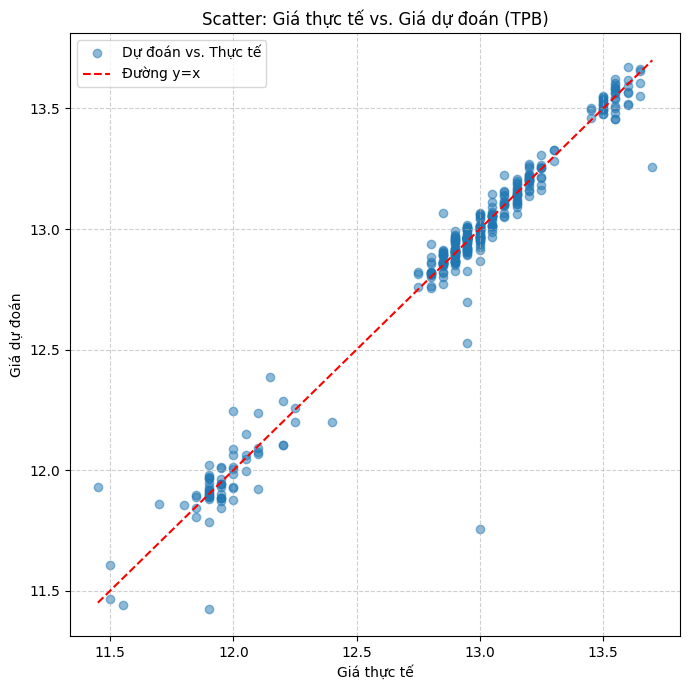

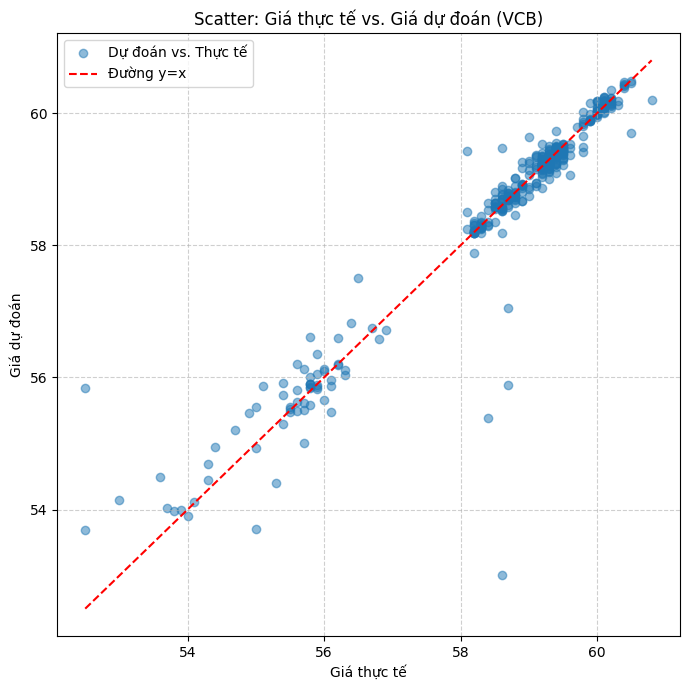

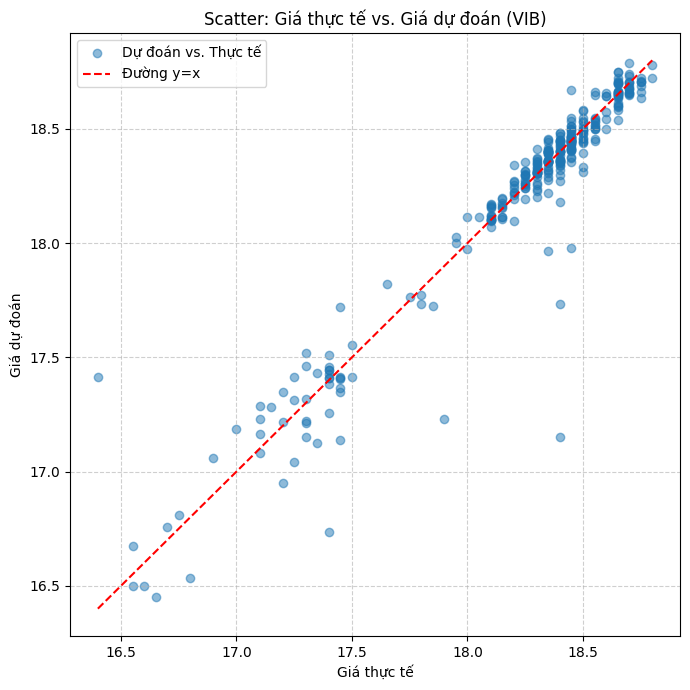

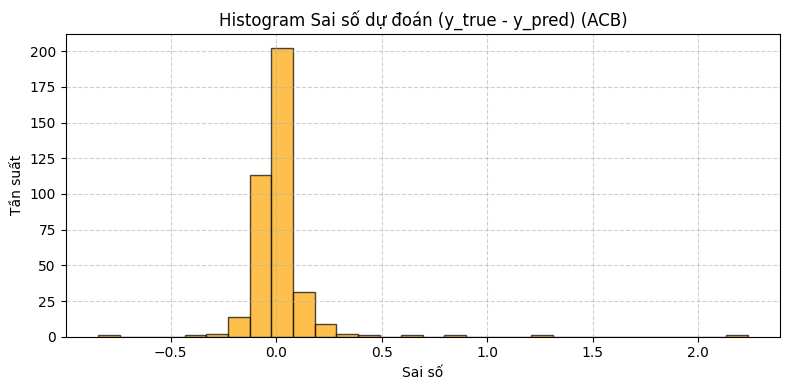

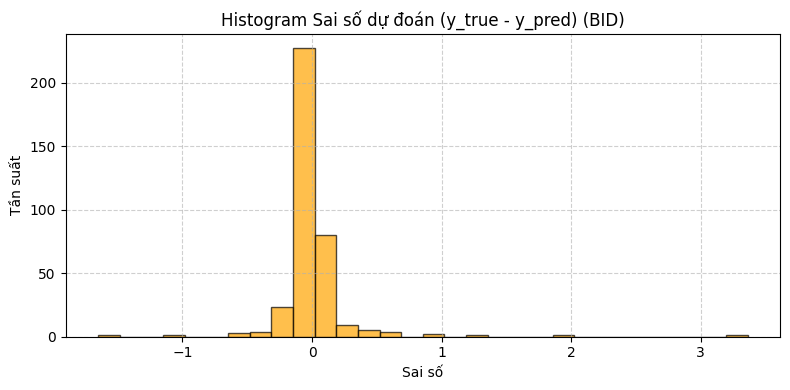

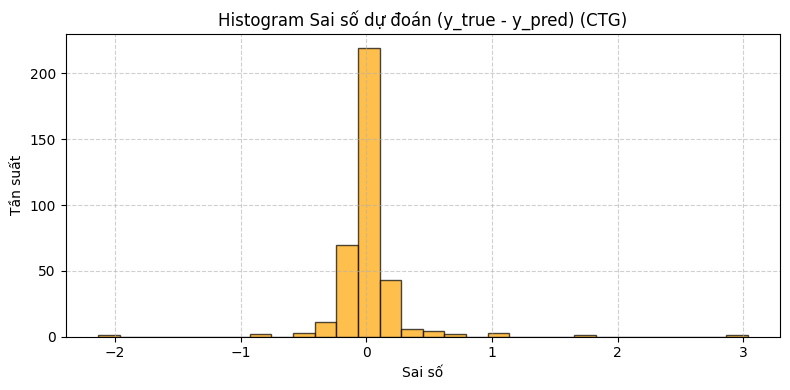

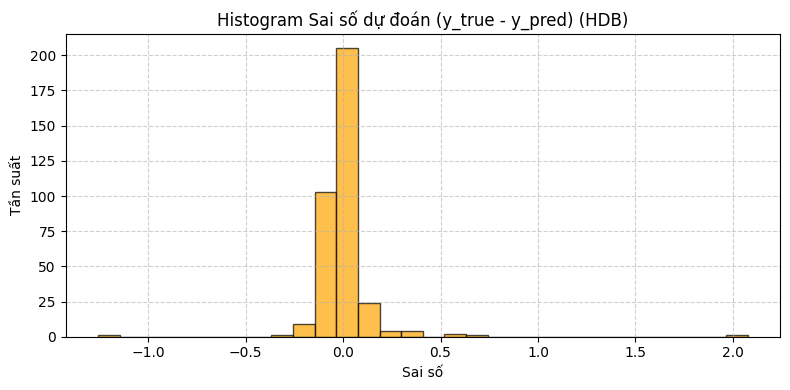

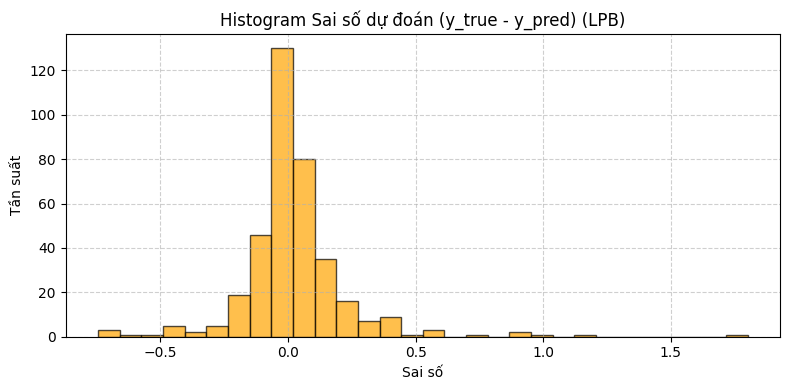

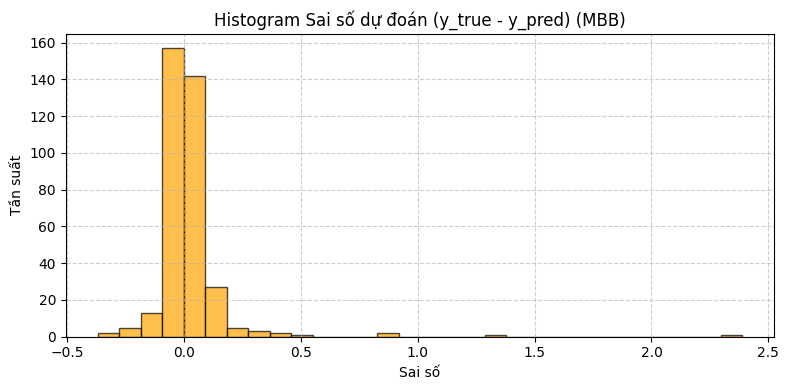

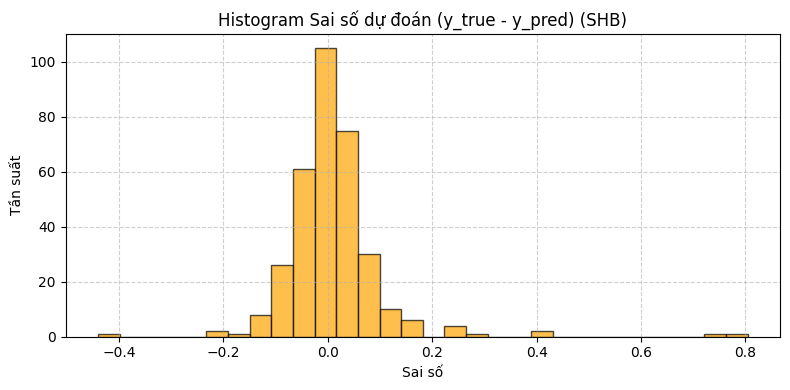

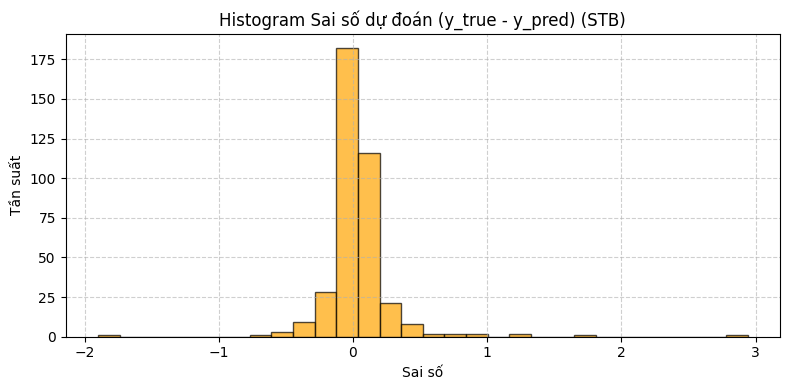

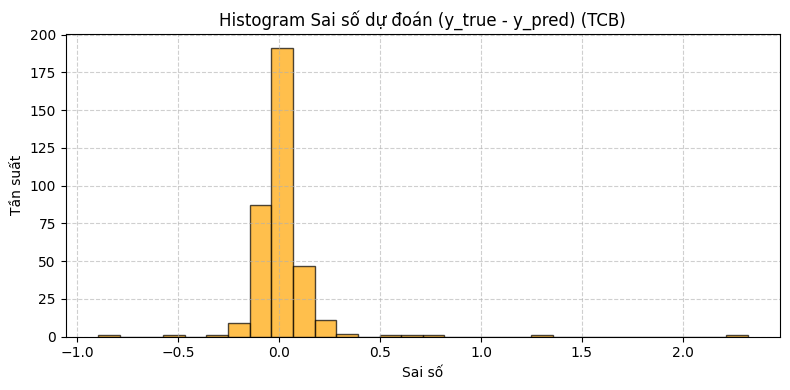

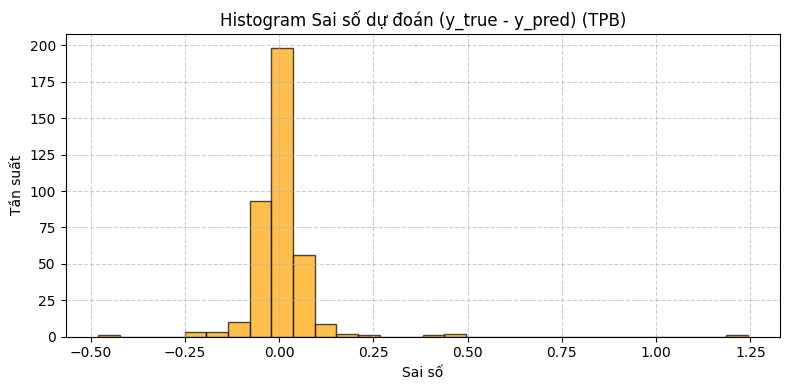

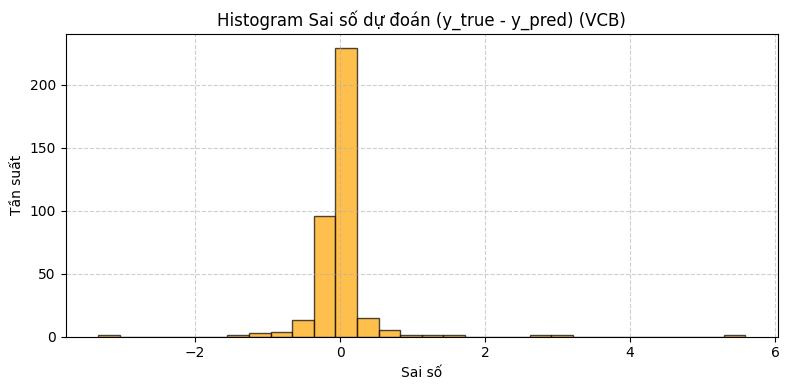

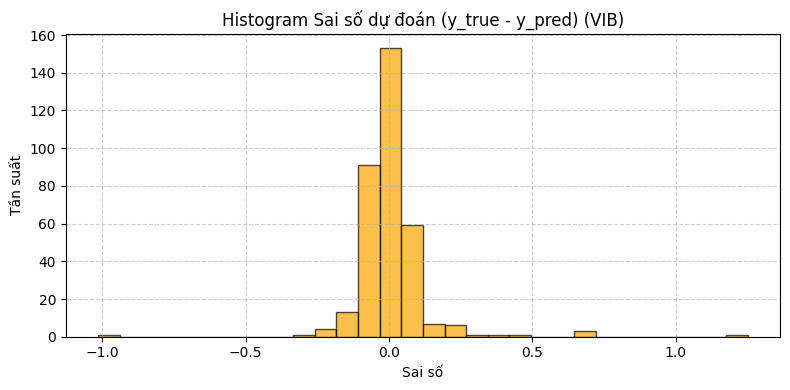

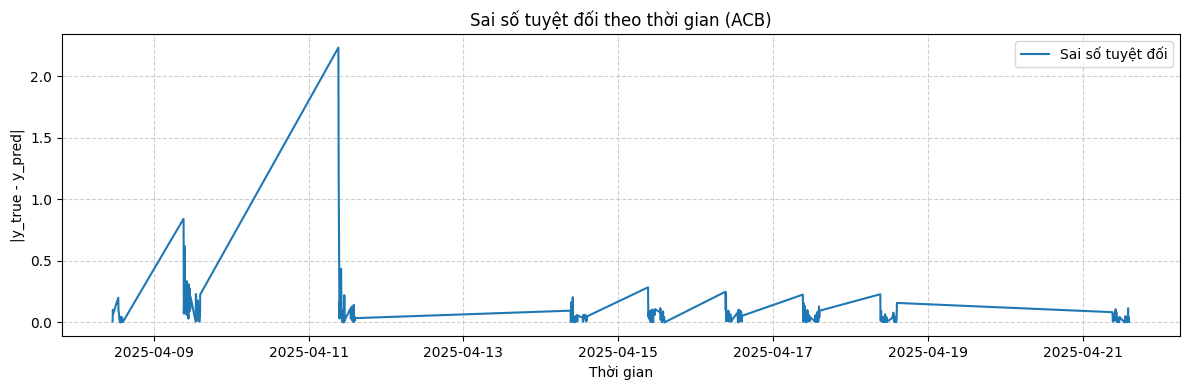

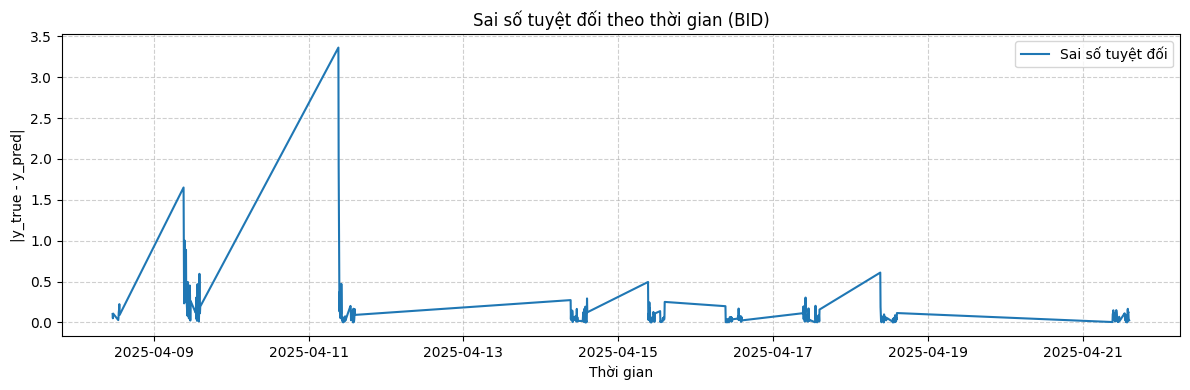

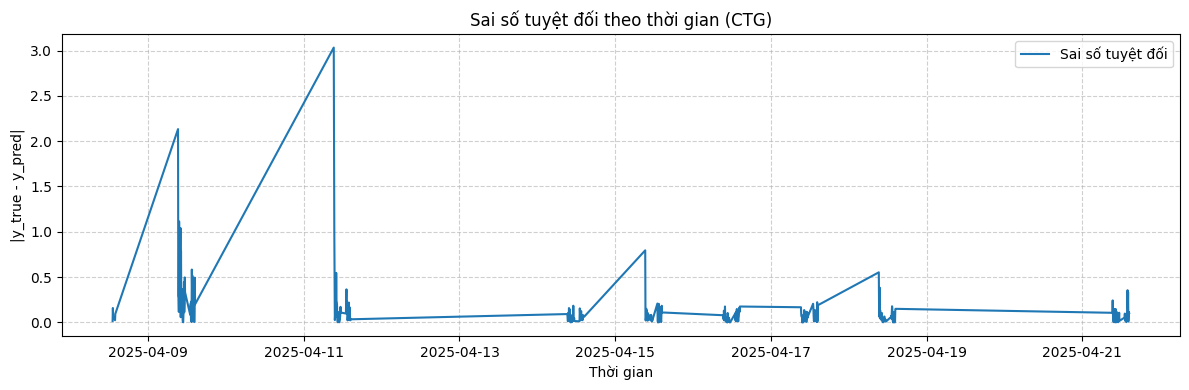

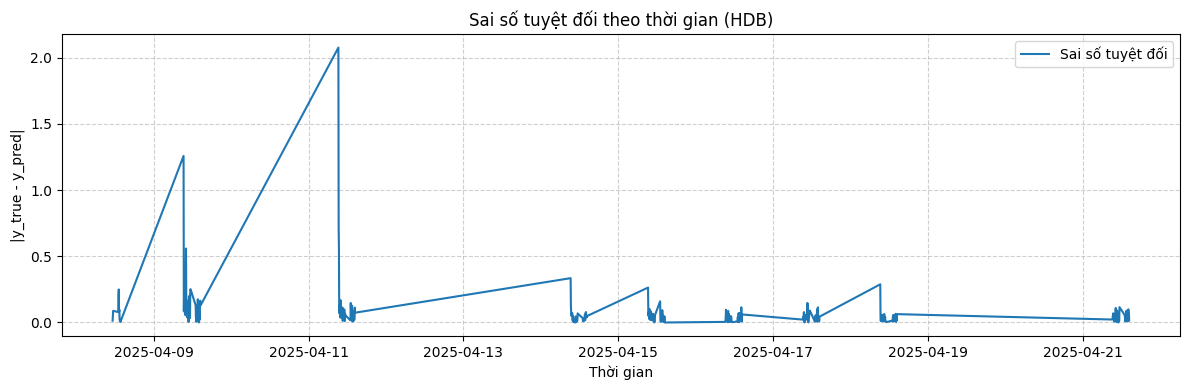

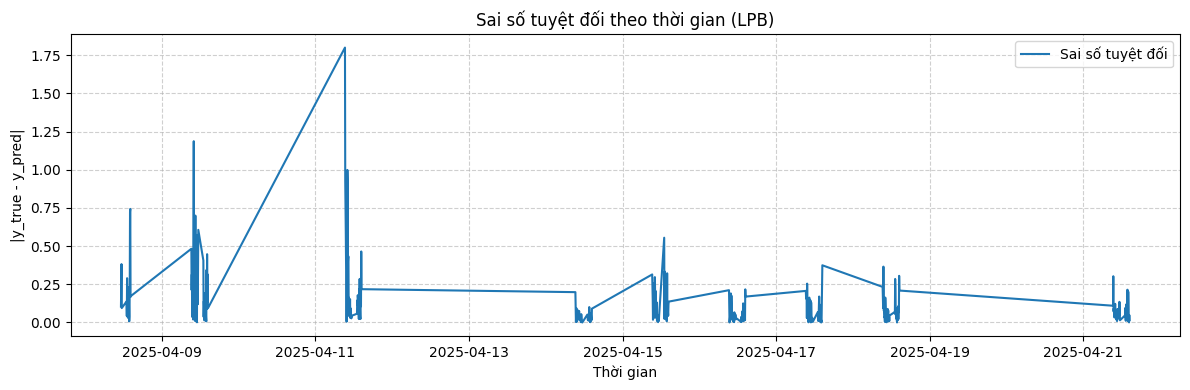

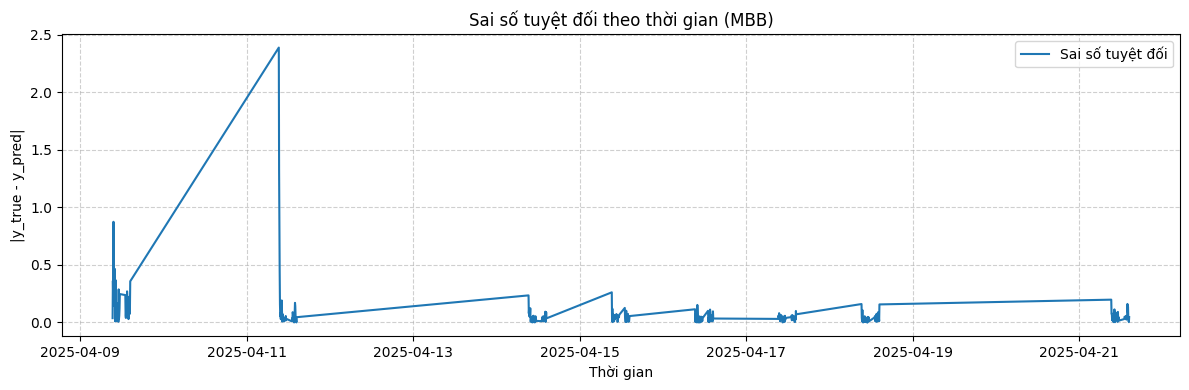

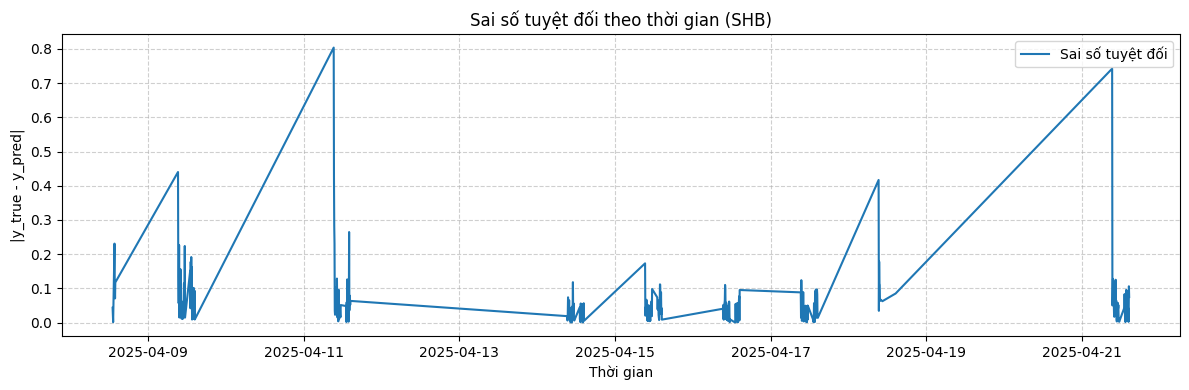

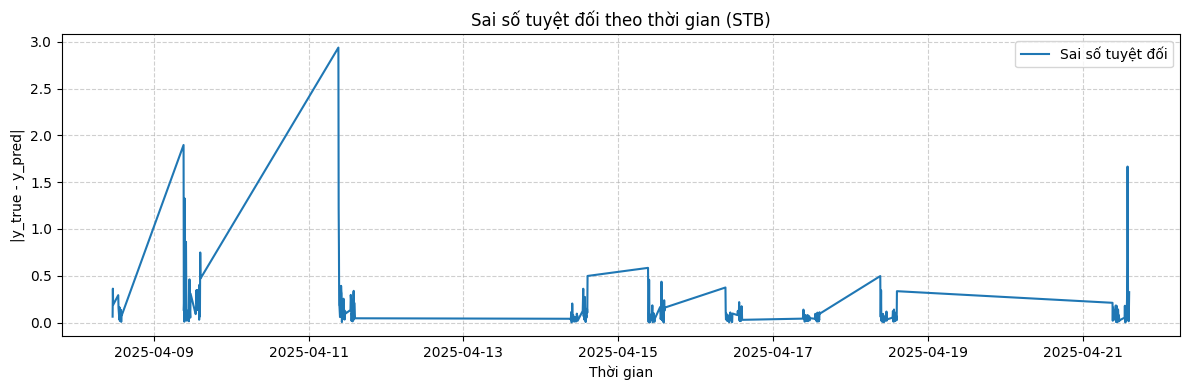

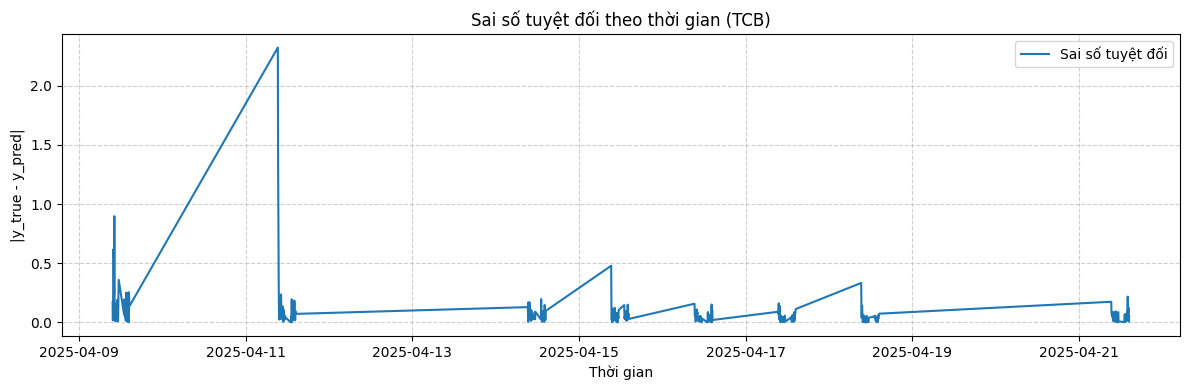

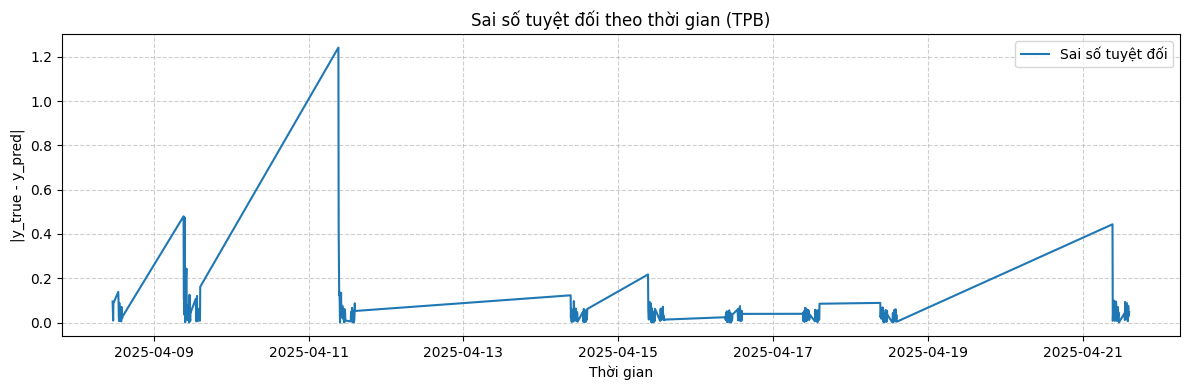

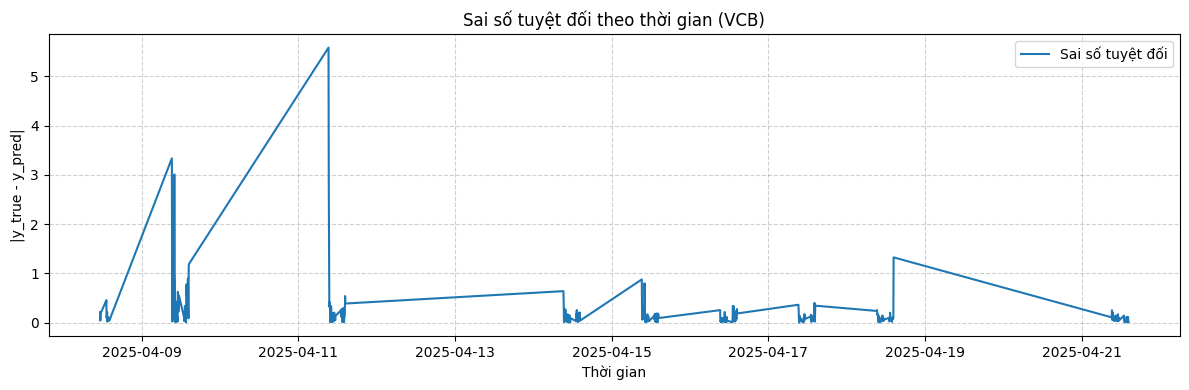

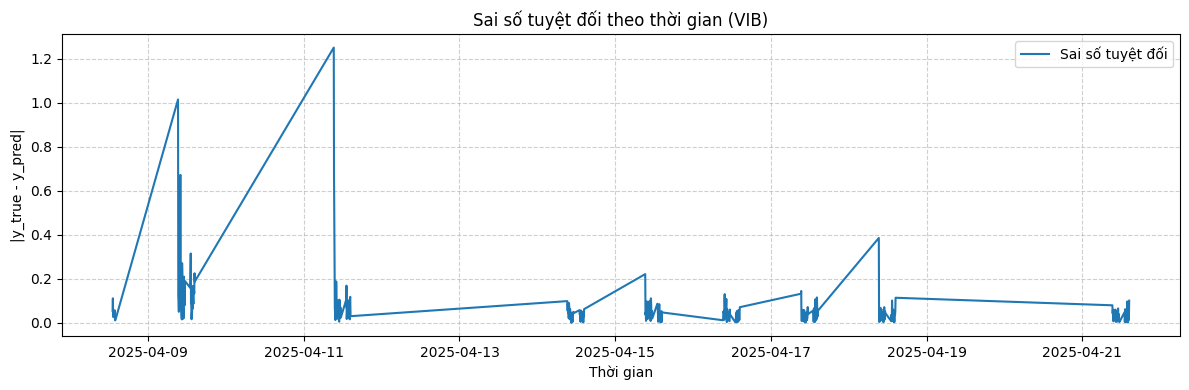

In [ ]:
import numpy as np
import pandas as pd
import os
import joblib
import warnings
import math
from datetime import datetime, timedelta
import time # Thêm thư viện time

# vnstock
try:
    from vnstock import Vnstock
except ImportError:
    print("Vui lòng cài đặt vnstock: pip install vnstock")
    exit()

# Các thành phần Scikit-learn
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

from tensorflow.keras.utils import Sequence

# Plotting imports
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings('ignore')
np.random.seed(42)

# Khối 2: Định nghĩa các Hằng số và Đường dẫn


STOCK_LIST_PREDICT = [
    'ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB',
    'STB', 'TCB', 'TPB', 'VCB', 'VIB']


STOCK_LIST_TRAINED = [
    'ACB', 'BID', 'CTG', 'HDB', 'LPB', 'MBB', 'SHB',
    'STB', 'TCB', 'TPB', 'VCB', 'VIB'
]


BASE_ARTIFACT_DIR = r"E:\important\AI\time_series" 
PREPROCESS_DIR = os.path.join(BASE_ARTIFACT_DIR, 'preprocessed_data')
MODEL_DIR = os.path.join(BASE_ARTIFACT_DIR, 'models')

PRIMARY_TIMEFRAME = '5m'
REQUIRED_OHLCV_COLS = ['open', 'high', 'low', 'close', 'volume']
WINDOW_SIZE = 5
HORIZON = 1
TARGET_COL_NAME = 'close'
USE_ROBUST_SCALER = False 

NEW_DATA_DIR = r"E:\important\AI\time_series\data"
os.makedirs(NEW_DATA_DIR, exist_ok=True)

print(f"Thư mục chứa scaler/encoder: {PREPROCESS_DIR}")
print(f"Thư mục chứa model: {MODEL_DIR}")
print(f"Các mã cổ phiếu sẽ dự đoán: {STOCK_LIST_PREDICT}")

# Khối 3: Hàm Lấy Dữ liệu Mới từ vnstock

def fetch_new_data(symbols, start_date_str, end_date_str, interval='5m', output_dir=None):
    """
    Lấy dữ liệu lịch sử mới nhất cho danh sách các mã cổ phiếu.
    """
    print(f"Đang lấy dữ liệu từ {start_date_str} đến {end_date_str} cho {len(symbols)} mã...")
    data_dict = {}
    vnstock_instance = Vnstock() # Khởi tạo một lần

    for s in symbols:
        print(f"  Đang lấy dữ liệu cho: {s}")
        try:
            stock_instance = vnstock_instance.stock(symbol=s, source='VCI')
            time.sleep(0.5)
            df = stock_instance.quote.history(start=start_date_str, end=end_date_str, interval=interval)

            if df is not None and not df.empty:
                if 'time' in df.columns:
                    df['time'] = pd.to_datetime(df['time'])
                    df.set_index('time', inplace=True)
                elif isinstance(df.index, pd.DatetimeIndex):
                    pass # Index đã là datetime rồi
                else:
                     print(f"Cảnh báo [{s}]: Không tìm thấy cột 'time' hoặc index không phải DatetimeIndex.")
                     continue

                df.sort_index(inplace=True)

                # Chỉ giữ lại các cột cần thiết ban đầu
                if all(col in df.columns for col in REQUIRED_OHLCV_COLS):
                    df = df[REQUIRED_OHLCV_COLS]
                    # Chuyển đổi kiểu dữ liệu sang số, lỗi thành NaN
                    for col in REQUIRED_OHLCV_COLS:
                        df[col] = pd.to_numeric(df[col], errors='coerce')
                    # Loại bỏ hàng có NaN trong các cột OHLCV cơ bản
                    initial_rows = len(df)
                    df.dropna(subset=REQUIRED_OHLCV_COLS, inplace=True)
                    rows_after_dropna = len(df)
                    if initial_rows > rows_after_dropna:
                        print(f"  [{s}] Đã loại bỏ {initial_rows - rows_after_dropna} hàng có NaN trong OHLCV.")

                    if not df.empty:
                        data_dict[s] = df
                        print(f"  [{s}] Lấy dữ liệu thành công. Shape: {df.shape}")
                        if output_dir:
                            output_path = os.path.join(output_dir, f"{s}_newdata_{interval}.csv")
                            df.to_csv(output_path)
                            # print(f"    Đã lưu vào: {output_path}")
                    else:
                        print(f"  [{s}] Dữ liệu trống sau khi làm sạch NaN.")
                else:
                    print(f"  Cảnh báo [{s}]: Dữ liệu trả về thiếu các cột OHLCV cần thiết.")
            else:
                print(f"  [{s}] Không lấy được dữ liệu hoặc dữ liệu trống.")

        except Exception as e:
            print(f"  Lỗi khi lấy dữ liệu cho mã {s}: {e}")
            time.sleep(1) # Chờ lâu hơn nếu có lỗi

    print(f"Hoàn tất lấy dữ liệu. Số mã thành công: {len(data_dict)}")
    return data_dict

end_date = datetime.now()
start_date = end_date - timedelta(days=14)

end_date_str = end_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')

# Lấy dữ liệu mới
new_data_raw = fetch_new_data(STOCK_LIST_PREDICT, start_date_str, end_date_str, PRIMARY_TIMEFRAME, NEW_DATA_DIR)

# Cập nhật lại danh sách mã thực sự có dữ liệu
STOCK_LIST_PREDICT = list(new_data_raw.keys())
if not STOCK_LIST_PREDICT:
    print("\nLỖI: Không lấy được dữ liệu mới cho bất kỳ mã nào. Thoát.")
    exit()
print(f"\nCác mã có dữ liệu mới để xử lý: {STOCK_LIST_PREDICT}")


# Khối 4: Hàm Tạo Đặc trưng Kỹ thuật (Copy từ Notebook)


def add_technical_indicators(df, symbol_name=""):
    df_with_features = df.copy()
    required_cols = ['open', 'high', 'low', 'close', 'volume']
    if not all(col in df_with_features.columns for col in required_cols):
        missing = [col for col in required_cols if col not in df_with_features.columns]
        print(f"CẢNH BÁO [{symbol_name}]: DataFrame thiếu các cột bắt buộc để tính chỉ báo: {missing}. Bỏ qua mã này.")
        return pd.DataFrame() 

    open_price = df_with_features['open']
    high = df_with_features['high']
    low = df_with_features['low']
    close = df_with_features['close']
    volume = df_with_features['volume'].clip(lower=1e-9)

    # EMA Ngắn hạn
    df_with_features['ema_5'] = close.ewm(span=5, adjust=False).mean()
    df_with_features['ema_12'] = close.ewm(span=12, adjust=False).mean()
    df_with_features['ema_26'] = close.ewm(span=26, adjust=False).mean()

    # MACD
    df_with_features['macd'] = df_with_features['ema_12'] - df_with_features['ema_26']
    df_with_features['macd_signal'] = df_with_features['macd'].ewm(span=9, adjust=False).mean()
    df_with_features['macd_diff'] = df_with_features['macd'] - df_with_features['macd_signal']

    # RSI (EWM)
    rsi_window = 9
    delta = close.diff()
    gain = delta.where(delta > 0, 0.0).ewm(alpha=1.0/rsi_window, adjust=False).mean()
    loss = (-delta.where(delta < 0, 0.0)).ewm(alpha=1.0/rsi_window, adjust=False).mean()
    loss_safe = loss.replace(0, 1e-9)
    rs = gain / loss_safe
    df_with_features['rsi'] = 100.0 - (100.0 / (1.0 + rs))
    df_with_features['rsi'] = df_with_features['rsi'].fillna(50)

    # ATR (EWM)
    atr_window = 10
    high_low = high - low
    high_close_prev = abs(high - close.shift())
    low_close_prev = abs(low - close.shift())
    ranges = pd.concat([high_low, high_close_prev, low_close_prev], axis=1)
    true_range = ranges.max(axis=1)
    df_with_features['atr'] = true_range.ewm(alpha=1.0/atr_window, adjust=False).mean()

    # Volume EMA
    vol_ema_window = 20
    df_with_features['volume_ema_20'] = volume.ewm(span=vol_ema_window, adjust=False).mean()

    # VWAP (Rolling)
    vwap_window = 20
    tp = (high + low + close) / 3
    vwap_numerator = (tp * volume).rolling(window=vwap_window).sum()
    vwap_denominator = volume.rolling(window=vwap_window).sum().replace(0, 1e-9)
    df_with_features['vwap_roll'] = vwap_numerator / vwap_denominator

    # Volatility (Std Dev of Log Returns)
    vol_window_short = 10
    vol_window_long = 20
    log_return = np.log(close / close.shift()).fillna(0)
    df_with_features[f'volatility_{vol_window_short}'] = log_return.rolling(window=vol_window_short).std() * np.sqrt(vol_window_short)
    df_with_features[f'volatility_{vol_window_long}'] = log_return.rolling(window=vol_window_long).std() * np.sqrt(vol_window_long)

    # Động lực của Chỉ báo
    df_with_features['rsi_roc_1'] = df_with_features['rsi'].diff()
    df_with_features['macd_diff_roc_1'] = df_with_features['macd_diff'].diff()

    # Chuẩn hóa Khoảng cách EMA
    ema_12_safe = df_with_features['ema_12'].replace(0, np.nan)
    df_with_features['ema_5_12_spread_pct'] = (df_with_features['ema_5'] - df_with_features['ema_12']) / ema_12_safe * 100

    # Động lực Biến động
    vol_long_safe = df_with_features[f'volatility_{vol_window_long}'].replace(0, np.nan)
    df_with_features['vol_short_long_ratio'] = df_with_features[f'volatility_{vol_window_short}'] / vol_long_safe
    df_with_features['atr_roc_1'] = df_with_features['atr'].diff()

    # Động lực Khối lượng
    vol_ema_safe = df_with_features['volume_ema_20'].replace(0, np.nan)
    df_with_features['volume_spike_factor'] = volume / vol_ema_safe
    df_with_features['price_change_x_volume'] = close.diff() * volume
    df_with_features['log_return_x_volume'] = log_return * volume

    # Đặc trưng Vi cấu trúc Nến
    df_with_features['candle_body_size'] = abs(close - open_price)
    df_with_features['candle_upper_wick'] = high - np.maximum(open_price, close)
    df_with_features['candle_lower_wick'] = np.minimum(open_price, close) - low
    candle_range = (high - low).replace(0, np.nan)
    df_with_features['candle_body_ratio'] = df_with_features['candle_body_size'] / candle_range

    # Tương tác Giá - VWAP - ATR
    atr_safe = df_with_features['atr'].replace(0, np.nan)
    df_with_features['price_vwap_dist_atr'] = (close - df_with_features['vwap_roll']) / atr_safe

    # Chỉ báo được làm mượt
    df_with_features['rsi_smoothed_3'] = df_with_features['rsi'].ewm(span=3, adjust=False).mean()

    # Xử lý NaN cuối cùng
    df_with_features.replace([np.inf, -np.inf], np.nan, inplace=True)
    initial_len = len(df_with_features)
    df_with_features.dropna(inplace=True) # Quan trọng: dropna sau khi tính toán
    final_len = len(df_with_features)
    rows_dropped = initial_len - final_len
    if rows_dropped > 0:
        print(f"[{symbol_name}] Đã loại bỏ {rows_dropped} hàng đầu do NaN từ tính toán chỉ báo.")

    return df_with_features

print("\nĐang thêm các chỉ báo kỹ thuật vào dữ liệu mới...")
new_data_with_indicators = {}
successful_symbols_indicators = []
for symbol in STOCK_LIST_PREDICT: 
    if symbol in new_data_raw:
        df_raw = new_data_raw[symbol]
        processed_df = add_technical_indicators(df_raw, symbol_name=symbol)
        if not processed_df.empty:
            # Kiểm tra xem có đủ dòng để tạo ít nhất 1 sequence không
            if len(processed_df) >= WINDOW_SIZE + HORIZON:
                 new_data_with_indicators[symbol] = processed_df
                 successful_symbols_indicators.append(symbol)
                 print(f"  [{symbol}] Thêm chỉ báo thành công. Shape: {processed_df.shape}")
            else:
                 print(f"  Cảnh báo [{symbol}]: Không đủ dữ liệu ({len(processed_df)} < {WINDOW_SIZE + HORIZON}) sau khi thêm chỉ báo. Bỏ qua.")
        else:
            print(f"  Cảnh báo [{symbol}]: DataFrame trống sau khi thêm chỉ báo. Bỏ qua.")
    else:
        print(f"  Bỏ qua [{symbol}] vì không có dữ liệu raw ban đầu.")


STOCK_LIST_PREDICT = successful_symbols_indicators # Cập nhật lại danh sách
if not STOCK_LIST_PREDICT:
    print("\nLỖI: Không còn mã cổ phiếu nào có đủ dữ liệu sau khi thêm chỉ báo. Thoát.")
    exit()
print(f'\nCác mã có đủ dữ liệu để tiếp tục xử lý: {STOCK_LIST_PREDICT}')


# Khối 5: Tải Scaler, Encoder và Định nghĩa Lại DataProcessor 
# 

class DataProcessor:
    """Lớp xử lý chuẩn hóa và mã hóa cho dữ liệu"""
    def __init__(self, stock_list_trained): # Thêm stock_list_trained vào init
        self.scaler = None
        self.encoder = None
        self.numeric_columns_ = None
        self.encoded_feature_names_ = None
        self.n_features_in_ = None
        self.fitted_ = False
        self.target_col_index_in_numeric_ = -1
        self.stock_list_trained = stock_list_trained # Lưu lại danh sách mã đã huấn luyện

    def load_fitted_state(self, preprocess_dir):
        """Tải trạng thái đã fit từ các file đã lưu."""
        try:
            self.scaler = joblib.load(os.path.join(preprocess_dir, 'feature_scaler.pkl'))
            self.encoder = joblib.load(os.path.join(preprocess_dir, 'symbol_encoder.pkl'))
            self.numeric_columns_ = joblib.load(os.path.join(preprocess_dir, 'numeric_columns.pkl'))
            self.encoded_feature_names_ = joblib.load(os.path.join(preprocess_dir, 'encoded_feature_names.pkl'))
            self.target_col_index_in_numeric_ = joblib.load(os.path.join(preprocess_dir, 'target_col_index.pkl'))
            # Xác định n_features_in_ từ scaler đã load
            if hasattr(self.scaler, 'n_features_in_'):
                 self.n_features_in_ = self.scaler.n_features_in_
            elif hasattr(self.scaler, 'n_samples_seen_'): # RobustScaler có thể không có n_features_in_
                 # Cần kiểm tra số lượng cột trong numeric_columns_
                 self.n_features_in_ = len(self.numeric_columns_)
            else:
                 print("Cảnh báo: Không thể xác định n_features_in_ từ scaler đã tải.")
                 # Ước lượng dựa trên số cột numeric
                 self.n_features_in_ = len(self.numeric_columns_)


            self.fitted_ = True
            print("Đã tải thành công Scaler, Encoder và thông tin cột.")
            # Kiểm tra xem target_col_name có trong numeric_columns_ không
            if TARGET_COL_NAME not in self.numeric_columns_:
                 print(f"LỖI NGHIÊM TRỌNG: Cột target '{TARGET_COL_NAME}' không có trong danh sách cột numeric đã lưu!")
                 self.fitted_ = False # Đánh dấu là chưa sẵn sàng
                 return False
            # Kiểm tra lại index của target column
            try:
                recalculated_index = self.numeric_columns_.index(TARGET_COL_NAME)
                if recalculated_index != self.target_col_index_in_numeric_:
                    print(f"Cảnh báo: Index cột target đã lưu ({self.target_col_index_in_numeric_}) khác với index tính lại ({recalculated_index}). Sử dụng index tính lại.")
                    self.target_col_index_in_numeric_ = recalculated_index
            except ValueError:
                 print(f"LỖI NGHIÊM TRỌNG: Không tìm thấy cột target '{TARGET_COL_NAME}' trong numeric_columns_ khi kiểm tra lại.")
                 self.fitted_ = False
                 return False

            return True
        except FileNotFoundError as e:
            print(f"Lỗi: Không tìm thấy file artifact cần thiết: {e}")
            self.fitted_ = False
            return False
        except Exception as e:
            print(f"Lỗi khi tải trạng thái đã fit: {e}")
            self.fitted_ = False
            return False

    def _prepare_combined_data(self, data_dict, symbols_to_process):
        """Kết hợp dữ liệu, reset index và trả về index gốc."""
        all_data = []
        original_row_indices = {}
        current_pos = 0
        # Chỉ xử lý các mã có trong data_dict VÀ nằm trong danh sách symbols_to_process
        valid_symbols_in_dict = [s for s in symbols_to_process if s in data_dict and not data_dict[s].empty]

        if not valid_symbols_in_dict:
             return pd.DataFrame(), {}, [], pd.Index([])

        for symbol in valid_symbols_in_dict:
            df = data_dict[symbol].copy()
            # Quan trọng: Sử dụng danh sách mã đã huấn luyện cho encoder
            df['symbol_cat_temp'] = symbol
            all_data.append(df)
            start_row = current_pos
            end_row = current_pos + len(df)
            original_row_indices[symbol] = (start_row, end_row)
            current_pos = end_row

        if not all_data: # Kiểm tra nếu không có dữ liệu nào được thêm
             return pd.DataFrame(), {}, [], pd.Index([])

        combined_data = pd.concat(all_data, axis=0, ignore_index=False)
        original_dt_index = combined_data.index
        combined_data.reset_index(drop=True, inplace=True)

        return combined_data, original_row_indices, valid_symbols_in_dict, original_dt_index

    def transform(self, data_dict, symbols_to_process):
        """Transform dữ liệu mới dùng scaler và encoder đã fit."""
        if not self.fitted_:
            print("Lỗi: Bộ xử lý chưa được tải hoặc tải lỗi. Không thể transform.")
            return {}

        # Chỉ chuẩn bị dữ liệu cho các mã được yêu cầu
        combined_data, original_row_indices, valid_symbols, original_dt_index = self._prepare_combined_data(data_dict, symbols_to_process)

        if combined_data.empty:
            print("Cảnh báo: Không có dữ liệu hợp lệ để transform.")
            return {}

        current_numeric_cols = combined_data.select_dtypes(include=np.number).columns.tolist()
        cols_to_scale = [col for col in self.numeric_columns_ if col in current_numeric_cols]
        if len(cols_to_scale) != len(self.numeric_columns_):
             missing_in_new_data = [col for col in self.numeric_columns_ if col not in current_numeric_cols]
             print(f"Cảnh báo: Dữ liệu mới thiếu các cột numeric đã dùng để fit scaler: {missing_in_new_data}")
             print(f"Sẽ chỉ chuẩn hóa {len(cols_to_scale)} cột có mặt.")
             if TARGET_COL_NAME not in cols_to_scale:
                 print(f"LỖI NGHIÊM TRỌNG: Cột target '{TARGET_COL_NAME}' bị thiếu trong dữ liệu mới sau khi tính chỉ báo!")
                 return {}

        try:
            numeric_data = combined_data[self.numeric_columns_].values
        except KeyError as e:
            print(f"Lỗi KeyError khi truy cập cột numeric: {e}. Có thể do thiếu cột trong dữ liệu mới.")
            print(f"Các cột numeric mong đợi: {self.numeric_columns_}")
            print(f"Các cột có trong combined_data: {combined_data.columns.tolist()}")
            return {}

        scaled_numeric_values = self.scaler.transform(numeric_data)
        scaled_numeric_df = pd.DataFrame(scaled_numeric_values, columns=self.numeric_columns_, index=combined_data.index)

        # --- Mã hóa One-Hot ---
        if 'symbol_cat_temp' not in combined_data.columns:
             print("Lỗi: Thiếu cột 'symbol_cat_temp' để mã hóa.")
             return {}
        symbols_array = combined_data[['symbol_cat_temp']]
        symbol_encoded_values = self.encoder.transform(symbols_array)
        encoded_df = pd.DataFrame(symbol_encoded_values, columns=self.encoded_feature_names_, index=combined_data.index)

        # --- Kết hợp lại ---
        final_feature_names = self.numeric_columns_ + self.encoded_feature_names_.tolist()
        final_df = pd.concat([scaled_numeric_df, encoded_df], axis=1)


        transformed_dict = {}
        for symbol, (start_row, end_row) in original_row_indices.items():
            # Kiểm tra start_row và end_row hợp lệ
            if start_row < len(final_df) and end_row <= len(final_df):
                symbol_df_processed = final_df.iloc[start_row:end_row].copy()
                # Lấy index datetime gốc tương ứng
                if start_row < len(original_dt_index) and end_row <= len(original_dt_index):
                    symbol_dt_index = original_dt_index[start_row:end_row]
                    symbol_df_processed.index = symbol_dt_index
                    transformed_dict[symbol] = symbol_df_processed
                else:
                    print(f"Cảnh báo [{symbol}]: Lỗi index datetime khi tách dữ liệu đã transform.")
            else:
                 print(f"Cảnh báo [{symbol}]: Lỗi index ({start_row}:{end_row}) khi tách dữ liệu đã transform (len={len(final_df)}).")


        return transformed_dict

    def inverse_transform_target(self, scaled_target_values):
        """Chuyển đổi ngược giá trị của cột target về thang đo gốc."""
        if not self.fitted_:
            print("Lỗi: Bộ xử lý chưa được tải hoặc tải lỗi. Không thể inverse_transform.")
            return np.array([])
        if self.target_col_index_in_numeric_ < 0:
             print("Lỗi: Index của cột target không hợp lệ.")
             return np.array([])
        if self.n_features_in_ is None or self.n_features_in_ <= 0:
             print("Lỗi: Số lượng features của scaler không hợp lệ.")
             return np.array([])


        num_scaler_features = self.n_features_in_
        scaled_values_flat = np.array(scaled_target_values).flatten()

        # Kiểm tra nếu đầu vào rỗng
        if scaled_values_flat.size == 0:
            return np.array([])

        dummy_array = np.zeros((len(scaled_values_flat), num_scaler_features))

        # Kiểm tra index có hợp lệ không
        if self.target_col_index_in_numeric_ >= num_scaler_features:
             print(f"Lỗi: target_col_index_in_numeric_ ({self.target_col_index_in_numeric_}) >= num_scaler_features ({num_scaler_features}).")
             return np.array([])

        dummy_array[:, self.target_col_index_in_numeric_] = scaled_values_flat
        try:
            inversed_array = self.scaler.inverse_transform(dummy_array)
            return inversed_array[:, self.target_col_index_in_numeric_]
        except ValueError as e:
             print(f"Lỗi trong quá trình inverse_transform của scaler: {e}")
             print(f"Shape của dummy_array: {dummy_array.shape}")
             print(f"Số features mong đợi của scaler: {self.scaler.n_features_in_ if hasattr(self.scaler, 'n_features_in_') else 'Không rõ'}")
             return np.array([])

# Khởi tạo và tải DataProcessor
data_processor = DataProcessor(stock_list_trained=STOCK_LIST_TRAINED)
if not data_processor.load_fitted_state(PREPROCESS_DIR):
    print("\nLỖI: Không thể tải các thành phần tiền xử lý. Thoát.")
    exit()

# Áp dụng transform cho dữ liệu mới
print("\nĐang chuẩn hóa và mã hóa dữ liệu mới...")
scaled_encoded_new_data = data_processor.transform(new_data_with_indicators, STOCK_LIST_PREDICT)

# Cập nhật lại danh sách mã thực sự có dữ liệu sau khi transform
processed_symbols = list(scaled_encoded_new_data.keys())
if not processed_symbols:
    print("\nLỖI: Không có dữ liệu nào được xử lý thành công (scaled/encoded). Thoát.")
    exit()
print(f"\nCác mã có dữ liệu đã được chuẩn hóa/mã hóa: {processed_symbols}")

# Lấy danh sách tên features cuối cùng từ data_processor
sequence_feature_names = data_processor.numeric_columns_ + data_processor.encoded_feature_names_.tolist()
print(f"Tổng số features cho mô hình: {len(sequence_feature_names)}")


# Khối 6: Định nghĩa Lại Data Generator (Flattened)
# 

class StockDataSequenceFlattened(Sequence):
    """Lớp tạo batch dữ liệu ĐÃ LÀM PHẲNG cho Keras Sequence (Dùng cho SGD)."""
    def __init__(self, data_dict, window_size, horizon, batch_size,
                 target_col_name='close', feature_list=None, shuffle=False): # Đặt shuffle=False mặc định cho dự đoán
        self.data_dict = data_dict
        self.window_size = window_size
        self.horizon = horizon
        self.batch_size = batch_size
        self.target_col_name = target_col_name
        self.shuffle = shuffle # Cho phép shuffle nếu muốn (nhưng không nên cho dự đoán)
        self.feature_list = feature_list

        # Chỉ lấy dữ liệu từ các mã có trong data_dict và không rỗng
        self.stock_data_arrays = {symbol: df.values for symbol, df in self.data_dict.items()
                                  if isinstance(df, pd.DataFrame) and not df.empty}
        self.valid_symbols = list(self.stock_data_arrays.keys())

        if not self.valid_symbols:
             # Không raise lỗi, chỉ cảnh báo và khởi tạo rỗng
             print("Cảnh báo: Không có dữ liệu hợp lệ nào được cung cấp cho StockDataSequenceFlattened.")
             self.indices = []
             self.feature_list = []
             self.target_col_index_in_features = -1
             self.n_flat_features = 0
             return # Thoát khỏi init

        # Xác định feature_list nếu chưa có
        if not self.feature_list:
            first_symbol = self.valid_symbols[0]
            # Lấy tên cột từ DataFrame gốc trong data_dict
            self.feature_list = self.data_dict[first_symbol].columns.tolist()

        # Tìm index cột target
        try:
            self.target_col_index_in_features = self.feature_list.index(self.target_col_name)
        except ValueError:
            print(f"LỖI: Cột target '{self.target_col_name}' không tìm thấy trong feature_list: {self.feature_list}")
            # Xử lý lỗi: có thể raise hoặc đặt index không hợp lệ và trả về batch rỗng sau này
            self.target_col_index_in_features = -1
            self.indices = []
            self.n_flat_features = 0
            return

        self.indices = []
        self.original_indices_map = [] # Lưu (symbol, original_dataframe_index_for_target)
        for symbol in self.valid_symbols:
            stock_values = self.stock_data_arrays[symbol]
            original_df = self.data_dict[symbol] # Lấy lại DataFrame gốc để lấy index thời gian
            n_samples = len(stock_values)
            last_valid_start_index = n_samples - self.window_size - self.horizon
            if last_valid_start_index >= 0:
                for i in range(last_valid_start_index + 1):
                    self.indices.append((symbol, i))
                    # Tính index trong DataFrame gốc tương ứng với target y
                    target_original_idx_pos = i + self.window_size + self.horizon - 1
                    # Lấy giá trị index (timestamp) thực tế
                    original_timestamp = original_df.index[target_original_idx_pos]
                    self.original_indices_map.append({'symbol': symbol, 'gen_index': len(self.indices)-1, 'target_timestamp': original_timestamp})


        if not self.indices and self.valid_symbols:
             print(f"Cảnh báo: Không tạo được index hợp lệ nào cho generator phẳng (Symbols: {self.valid_symbols}). Kiểm tra window/horizon/data length.")

        self.n_flat_features = self.window_size * len(self.feature_list)
        self.on_epoch_end() # Gọi để shuffle (nếu shuffle=True)

    def __len__(self):
        """Số lượng batch trên mỗi epoch."""
        if not self.indices: return 0
        # Xử lý trường hợp batch_size = 0 hoặc âm
        if self.batch_size <= 0:
             print("Cảnh báo: batch_size không hợp lệ, đặt về 1.")
             self.batch_size = 1
        return math.ceil(len(self.indices) / self.batch_size)

    def __getitem__(self, index):
        """Tạo một batch dữ liệu."""
        if not self.indices or self.target_col_index_in_features < 0:
             return np.array([]), np.array([]) # Return empty if no indices or target invalid

        batch_start = index * self.batch_size
        batch_end = min((index + 1) * self.batch_size, len(self.indices))
        batch_index_tuples = self.indices[batch_start:batch_end]

        current_batch_size = len(batch_index_tuples)
        if current_batch_size == 0: return np.array([]), np.array([])

        X_batch_flat = np.zeros((current_batch_size, self.n_flat_features), dtype=np.float32)
        y_batch = np.zeros(current_batch_size, dtype=np.float32)

        for i, (symbol, start_idx) in enumerate(batch_index_tuples):
            # Kiểm tra xem symbol có còn hợp lệ không (phòng trường hợp data_dict thay đổi)
            if symbol not in self.stock_data_arrays: continue

            stock_values = self.stock_data_arrays[symbol]
            seq_end_idx = start_idx + self.window_size
            target_time_index = start_idx + self.window_size + self.horizon - 1

            # Kiểm tra kỹ lưỡng index trước khi truy cập
            if seq_end_idx <= len(stock_values) and target_time_index < len(stock_values):
                x_seq_3d = stock_values[start_idx : seq_end_idx, :]
                # Kiểm tra số chiều của x_seq_3d trước khi reshape
                if x_seq_3d.ndim == 2:
                    X_batch_flat[i, :] = x_seq_3d.reshape(-1) # Làm phẳng
                    y_batch[i] = stock_values[target_time_index, self.target_col_index_in_features]
                else:
                    print(f"Cảnh báo: Dữ liệu slice cho [{symbol}] tại index {start_idx} không có dạng 2D.")
            # else: # Gỡ comment để debug nếu cần
            #     print(f"Cảnh báo: Index out of bounds trong __getitem__ cho {symbol}, start_idx {start_idx}, len {len(stock_values)}")

        return X_batch_flat, y_batch

    def on_epoch_end(self):
        """Xáo trộn index """
        if self.shuffle:
            np.random.shuffle(self.indices)
            pass


    def get_all_data_flattened(self):
        """Lấy toàn bộ dữ liệu X đã làm phẳng và y tương ứng."""
        if not self.indices or self.target_col_index_in_features < 0:
            return np.array([]), np.array([]), []

        num_samples = len(self.indices)
        all_X_flat = np.zeros((num_samples, self.n_flat_features), dtype=np.float32)
        all_y = np.zeros(num_samples, dtype=np.float32)
        all_timestamps = [] # Danh sách các timestamp tương ứng với all_y

        for i, (symbol, start_idx) in enumerate(self.indices):
             if symbol not in self.stock_data_arrays: continue
             stock_values = self.stock_data_arrays[symbol]
             original_df = self.data_dict[symbol] # Để lấy timestamp

             seq_end_idx = start_idx + self.window_size
             target_time_index = start_idx + self.window_size + self.horizon - 1

             if seq_end_idx <= len(stock_values) and target_time_index < len(stock_values):
                 x_seq_3d = stock_values[start_idx : seq_end_idx, :]
                 if x_seq_3d.ndim == 2:
                     all_X_flat[i, :] = x_seq_3d.reshape(-1)
                     all_y[i] = stock_values[target_time_index, self.target_col_index_in_features]
                     # Lấy timestamp từ DataFrame gốc
                     all_timestamps.append(original_df.index[target_time_index])
                 else:
                     # Nếu có lỗi, thêm giá trị placeholder hoặc NaN để giữ đúng kích thước
                     all_timestamps.append(pd.NaT) # Thêm NaT nếu không lấy được timestamp
             else:
                 all_timestamps.append(pd.NaT) # Thêm NaT nếu index lỗi

        # Lọc bỏ các mẫu có timestamp NaT nếu có lỗi xảy ra
        valid_indices = [i for i, ts in enumerate(all_timestamps) if pd.notna(ts)]
        if len(valid_indices) < num_samples:
             print(f"Cảnh báo: Loại bỏ {num_samples - len(valid_indices)} mẫu do lỗi index hoặc timestamp.")
             all_X_flat = all_X_flat[valid_indices]
             all_y = all_y[valid_indices]
             all_timestamps = [all_timestamps[i] for i in valid_indices]


        return all_X_flat, all_y, all_timestamps

    def get_all_targets(self):
        """Lấy tất cả các giá trị target y (scaled)."""
        _, all_y, _ = self.get_all_data_flattened()
        return all_y

    def get_all_target_timestamps(self):
        """Lấy tất cả các timestamp tương ứng với target y."""
        _, _, all_timestamps = self.get_all_data_flattened()
        return all_timestamps


print("Đã định nghĩa lớp StockDataSequenceFlattened.")


# Khối 7: Tải Mô hình SGD và Thực hiện Dự đoán

sgd_model_path = os.path.join(MODEL_DIR, 'sgd_regressor_model (3).pkl')
sgd_model_loaded = None

# Tải mô hình
try:
    sgd_model_loaded = joblib.load(sgd_model_path)
    print(f"Đã tải mô hình SGDRegressor từ: {sgd_model_path}")
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file mô hình SGD tại '{sgd_model_path}'. Thoát.")
    exit()
except Exception as e:
    print(f"LỖI: Không thể tải mô hình SGD: {e}. Thoát.")
    exit()

# Chuẩn bị lưu kết quả dự đoán
predictions_all = {}

# Dự đoán cho từng mã cổ phiếu có dữ liệu đã xử lý
print("\nBắt đầu dự đoán...")
for symbol in processed_symbols:
    print(f"\n--- Dự đoán cho mã: {symbol} ---")
    if symbol not in scaled_encoded_new_data or scaled_encoded_new_data[symbol].empty:
        print(f"  [{symbol}] Không có dữ liệu đã xử lý để dự đoán. Bỏ qua.")
        continue

    # Tạo generator chỉ cho mã hiện tại
    temp_predict_dict = {symbol: scaled_encoded_new_data[symbol]}
    predict_generator = StockDataSequenceFlattened(
        data_dict=temp_predict_dict,
        window_size=WINDOW_SIZE,
        horizon=HORIZON,
        batch_size=1024, # Có thể dùng batch lớn cho dự đoán
        target_col_name=TARGET_COL_NAME,
        feature_list=sequence_feature_names, # Cung cấp danh sách feature đã có
        shuffle=False 
    )

    if len(predict_generator) == 0:
        print(f"  [{symbol}] Không tạo được batch nào từ generator dự đoán. Bỏ qua.")
        continue

    # Lấy toàn bộ dữ liệu X phẳng, y thực tế (scaled), và timestamps
    print(f"  [{symbol}] Đang chuẩn bị dữ liệu từ generator...")
    X_predict_flat, y_true_scaled, target_timestamps = predict_generator.get_all_data_flattened()

    if X_predict_flat.shape[0] == 0:
        print(f"  [{symbol}] Không lấy được dữ liệu X từ generator. Bỏ qua.")
        continue

    print(f"  [{symbol}] Số lượng mẫu để dự đoán: {X_predict_flat.shape[0]}")

    # Thực hiện dự đoán (trên dữ liệu scaled)
    print(f"  [{symbol}] Đang thực hiện dự đoán...")
    y_pred_scaled = sgd_model_loaded.predict(X_predict_flat)

    # Chuyển đổi ngược về thang đo gốc
    print(f"  [{symbol}] Đang chuyển đổi ngược kết quả...")
    y_pred_inverse = data_processor.inverse_transform_target(y_pred_scaled)
    y_true_inverse = data_processor.inverse_transform_target(y_true_scaled) # Chuyển đổi cả y thực tế để so sánh

    # Kiểm tra kết quả inverse transform
    if y_pred_inverse.size == 0 or y_true_inverse.size == 0 or len(target_timestamps) == 0:
         print(f"  [{symbol}] Lỗi trong quá trình inverse transform hoặc lấy timestamp. Bỏ qua.")
         continue

    # Đảm bảo độ dài khớp nhau sau tất cả các bước
    min_len = min(len(y_pred_inverse), len(y_true_inverse), len(target_timestamps))
    if min_len < len(target_timestamps):
         print(f"  [{symbol}] Cảnh báo: Độ dài không khớp sau xử lý, cắt về {min_len} điểm.")
         y_pred_inverse = y_pred_inverse[:min_len]
         y_true_inverse = y_true_inverse[:min_len]
         target_timestamps = target_timestamps[:min_len]

    if min_len == 0:
         print(f"  [{symbol}] Không còn điểm dữ liệu nào sau khi kiểm tra độ dài. Bỏ qua.")
         continue


    # Lưu kết quả
    predictions_all[symbol] = {
        'timestamps': target_timestamps,
        'y_true': y_true_inverse,
        'y_pred': y_pred_inverse
    }
    print(f"  [{symbol}] Dự đoán và lưu kết quả thành công cho {len(target_timestamps)} điểm.")

# Khối 8: Vẽ Biểu Đồ So Sánh

def plot_predictions(y_true, y_pred, timestamps, title, plot_limit=500):
    """Vẽ biểu đồ so sánh giá trị thực tế và giá trị dự đoán với trục thời gian."""
    plt.figure(figsize=(15, 7)) # Tăng kích thước biểu đồ
    limit = min(plot_limit, len(y_true), len(y_pred), len(timestamps))

    if limit == 0:
        print(f"Không có dữ liệu để vẽ biểu đồ cho: {title}")
        plt.close() # Đóng cửa sổ trống
        return

    # Sử dụng timestamps cho trục x
    plt.plot(timestamps[:limit], y_true[:limit], label='Giá thực tế', color='blue', marker='.', linestyle='-', markersize=4, linewidth=1.5)
    plt.plot(timestamps[:limit], y_pred[:limit], label='Giá dự đoán (SGD)', color='red', marker='x', linestyle='--', markersize=4, linewidth=1)

    plt.title(f'{title}\n({limit} điểm gần nhất)')
    plt.ylabel('Giá (Thang đo gốc)')
    plt.xlabel('Thời gian')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.xticks(rotation=45) 
    plt.tight_layout() 
    # plt.show() # Hiển thị và chờ đóng
    plt.show(block=False)
    plt.pause(2)

# --- Kết thúc copy hàm plot_predictions ---

# Vẽ biểu đồ cho từng mã
if not predictions_all:
    print("\nKhông có kết quả dự đoán nào để vẽ.")
else:
    print("\nĐang vẽ biểu đồ...")
    for symbol, results in predictions_all.items():
        plot_predictions(
            results['y_true'],
            results['y_pred'],
            results['timestamps'],
            f'So sánh Giá Thực tế vs. Dự đoán SGD: {symbol}'
        )
    print("\nHoàn tất vẽ biểu đồ. Kiểm tra các cửa sổ đồ thị đã hiển thị.")


# 1. Vẽ biểu đồ scatter giữa giá thực tế và giá dự đoán cho từng mã
for symbol in processed_symbols:
    results = predictions_all[symbol]
    y_true = results['y_true']
    y_pred = results['y_pred']
    plt.figure(figsize=(7, 7))
    plt.scatter(y_true, y_pred, alpha=0.5, label='Dự đoán vs. Thực tế')
    plt.plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], 'r--', label='Đường y=x')
    plt.xlabel('Giá thực tế')
    plt.ylabel('Giá dự đoán')
    plt.title(f'Scatter: Giá thực tế vs. Giá dự đoán ({symbol})')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 2. Vẽ biểu đồ histogram sai số dự đoán (y_true - y_pred) cho từng mã
for symbol in processed_symbols:
    results = predictions_all[symbol]
    errors = results['y_true'] - results['y_pred']
    plt.figure(figsize=(8, 4))
    plt.hist(errors, bins=30, color='orange', edgecolor='black', alpha=0.7)
    plt.title(f'Histogram Sai số dự đoán (y_true - y_pred) ({symbol})')
    plt.xlabel('Sai số')
    plt.ylabel('Tần suất')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

# 3. Vẽ biểu đồ đường sai số tuyệt đối theo thời gian cho từng mã
for symbol in processed_symbols:
    results = predictions_all[symbol]
    abs_error = np.abs(results['y_true'] - results['y_pred'])
    plt.figure(figsize=(12, 4))
    plt.plot(results['timestamps'], abs_error, label='Sai số tuyệt đối')
    plt.title(f'Sai số tuyệt đối theo thời gian ({symbol})')
    plt.xlabel('Thời gian')
    plt.ylabel('|y_true - y_pred|')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()


In [7]:
# Calculate loss metrics for each company
print("\n=== Metrics for Each Company ===")
company_metrics = {}

for symbol, results in predictions_all.items():
    y_true = results['y_true']
    y_pred = results['y_pred']
    
    # Calculate metrics
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    
    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    # Store metrics
    company_metrics[symbol] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'MAPE': mape
    }
    
    print(f"\n{symbol}:")
    print(f"MSE: {mse:.6f}")
    print(f"RMSE: {rmse:.6f}")
    print(f"MAE: {mae:.6f}")
    print(f"R2: {r2:.6f}")
    print(f"MAPE: {mape:.2f}%")

# Calculate average metrics across all companies
avg_metrics = {
    'MSE': np.mean([m['MSE'] for m in company_metrics.values()]),
    'RMSE': np.mean([m['RMSE'] for m in company_metrics.values()]),
    'MAE': np.mean([m['MAE'] for m in company_metrics.values()]),
    'R2': np.mean([m['R2'] for m in company_metrics.values()]),
    'MAPE': np.mean([m['MAPE'] for m in company_metrics.values()])
}

print("\n=== Average Metrics Across All Companies ===")
print(f"Average MSE: {avg_metrics['MSE']:.6f}")
print(f"Average RMSE: {avg_metrics['RMSE']:.6f}")
print(f"Average MAE: {avg_metrics['MAE']:.6f}")
print(f"Average R2: {avg_metrics['R2']:.6f}")
print(f"Average MAPE: {avg_metrics['MAPE']:.2f}%")


=== Metrics for Each Company ===

ACB:
MSE: 0.028867
RMSE: 0.169901
MAE: 0.070652
R2: 0.965406
MAPE: 0.30%

BID:
MSE: 0.079676
RMSE: 0.282270
MAE: 0.115334
R2: 0.939126
MAPE: 0.33%

CTG:
MSE: 0.079550
RMSE: 0.282046
MAE: 0.125292
R2: 0.917290
MAPE: 0.34%

HDB:
MSE: 0.025732
RMSE: 0.160411
MAE: 0.066332
R2: 0.951628
MAPE: 0.33%

LPB:
MSE: 0.049584
RMSE: 0.222675
MAE: 0.126032
R2: 0.937746
MAPE: 0.39%

MBB:
MSE: 0.032769
RMSE: 0.181022
MAE: 0.072694
R2: 0.955021
MAPE: 0.33%

SHB:
MSE: 0.009614
RMSE: 0.098051
MAE: 0.055931
R2: 0.967278
MAPE: 0.47%

STB:
MSE: 0.077586
RMSE: 0.278543
MAE: 0.132117
R2: 0.966334
MAPE: 0.36%

TCB:
MSE: 0.033447
RMSE: 0.182886
MAE: 0.079132
R2: 0.936218
MAPE: 0.31%

TPB:
MSE: 0.009069
RMSE: 0.095230
MAE: 0.045450
R2: 0.960134
MAPE: 0.36%

VCB:
MSE: 0.224764
RMSE: 0.474093
MAE: 0.185114
R2: 0.909407
MAPE: 0.32%

VIB:
MSE: 0.017716
RMSE: 0.133100
MAE: 0.065417
R2: 0.919557
MAPE: 0.36%

=== Average Metrics Across All Companies ===
Average MSE: 0.055698
Average RM

In [ ]:

metrics_to_plot = ['MSE', 'RMSE', 'MAE', 'MAPE']
plt.figure(figsize=(14, 8))

for i, metric in enumerate(metrics_to_plot, 1):
    plt.subplot(2, 2, i)
    values = [company_metrics[symbol][metric] for symbol in company_metrics]
    sns.barplot(x=list(company_metrics.keys()), y=values, palette='viridis')
    plt.title(metric)
    plt.xlabel('Mã công ty')
    plt.ylabel(metric)
    plt.xticks(rotation=30)
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

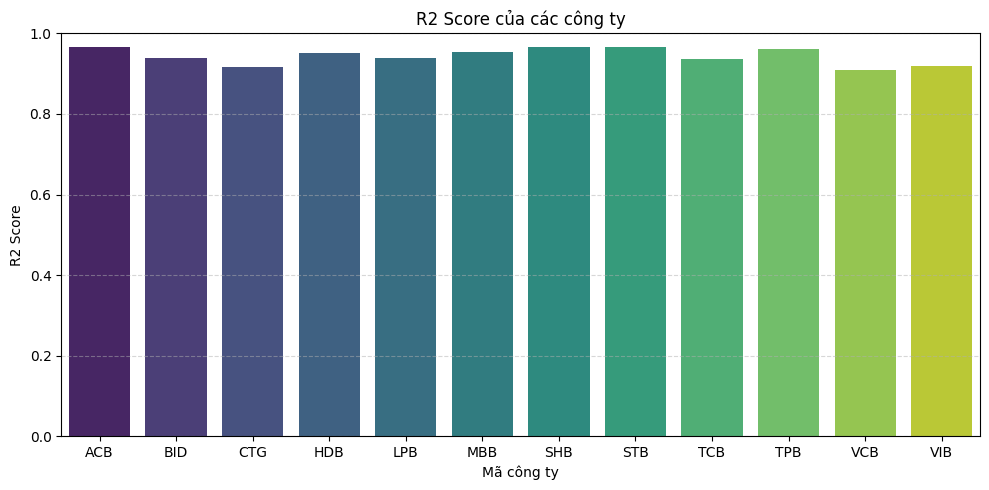

In [ ]:
company_names = list(company_metrics.keys())
r2_scores = [company_metrics[symbol]['R2'] for symbol in company_names]

plt.figure(figsize=(10, 5))
sns.barplot(x=company_names, y=r2_scores, palette='viridis')
plt.title('R2 Score của các công ty')
plt.xlabel('Mã công ty')
plt.ylabel('R2 Score')
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()